In [1]:
import sys
import os
import pandas as pd

sys.path.append(os.path.abspath("../../ml/"))

from dev_wtp_io_utils import *

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
# ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

sys.path.append(os.path.abspath("../../ml/"))
from apply_loocv_and_save import load_and_preprocess
from dev_utils import read_yaml_for_host, filter_dev_data
import warnings


config_data = read_yaml_for_host("sst_config.yml")



python initialized for apply_loocv_and_save
cpus available; cpus to use:
28 25
28
yaml file does not contain host-specific settings for this host. Using default settings.


In [3]:
nonbids_data_path = config_data['nonbids_data_path']
ml_data_folderpath = nonbids_data_path + "fMRI/ml"
dropbox_datapath = config_data['dropbox_datapath']


In [4]:
#test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20210601T183243.csv")
#test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20211027T173724.csv")
test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20230102T164214.csv")
train_subjects = filter_dev_data(test_train_df_raw, nonbids_data_path,dropbox_datapath)


ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [ ]:
def get_Brain_Data_for_sub(sub_label,behavdesign,betaseries_path='/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries_nos/'):
    return(dev_wtp_io_utils.get_Brain_Data_betas_for_sub(sub_label,behavdesign,betaseries_path))

In [79]:
from dev_wtp_io_utils import import_sst_cond_w1_subjs_to_pkl

In [80]:
all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")
#cut out other waves
sst_1_behavdesign_1 = all_sst_events[(all_sst_events.wave=='wave1')].reset_index(drop=True)
#label the ITI as such
sst_1_behavdesign_1.loc[(all_sst_events.trial_type.isna()),'trial_type']='ITI'
#ensure it is correctly ordered
sst_1_behavdesign_clean = sst_1_behavdesign_1.sort_values(['subject','onset']).reset_index(drop=True)
#now tell it the name of the corresponding beta. this is easy; they are all consecutive
sst_1_behavdesign_clean['beta'] = 'beta_' + (sst_1_behavdesign_clean.groupby(['subject','wave']).cumcount()+1).astype(str).apply(lambda x: x.zfill(4)) + '.nii'

In [81]:
all_sst_events[(all_sst_events.subject=='DEV013') & (all_sst_events.wave=="wave1")]

,onset,duration,trial_type,subject,wave
79872,0.00000,2.25834,correct-stop,DEV013,wave1
79873,2.25834,0.50000,NaN,DEV013,wave1
79874,2.75834,2.00556,failed-go,DEV013,wave1
79875,4.76390,0.75000,NaN,DEV013,wave1
79876,5.51390,0.48810,correct-go,DEV013,wave1
...,...,...,...,...,...
80123,412.82572,1.75000,NaN,DEV013,wave1
80124,414.57572,0.56873,correct-go,DEV013,wave1
80125,417.08682,0.75000,NaN,DEV013,wave1
80126,417.83682,1.50000,failed-stop,DEV013,wave1


In [82]:
#I want to import this other module; we don't actually use it but it's a good reference
#for future programmers to see
#it's important we keep the logic consistent for the two main conditions
sys.path.append(os.path.abspath("../../fx/multiconds/SST/"))
from multiconds import create_posterror_masks_from_masks

#sst_1_behavdesign_clean['prev_trial_type'] = sst_1_behavdesign_clean['trial_type']
sst_1_behavdesign_clean['prev_trial_type'] = (
    sst_1_behavdesign_clean
    .loc[sst_1_behavdesign_clean['trial_type']!='ITI']
    .groupby(['subject','wave'])
    .shift(1)
    ['trial_type']
)#this works because during assignment, items will be assigned to the line corresponding to their index
#very important you don't reset index during this operation.
is_post_stop_correct_go = (
    (sst_1_behavdesign_clean['trial_type']=='correct-go') & 
    (sst_1_behavdesign_clean['prev_trial_type'].isin(['failed-stop','correct-stop']))
)

sst_1_behavdesign_clean.loc[is_post_stop_correct_go,'post_stop_correct_go_subtype'] = 'Other'
sst_1_behavdesign_clean.loc[is_post_stop_correct_go & (sst_1_behavdesign_clean['prev_trial_type']=='failed-stop'),'post_stop_correct_go_subtype'] = 'post-error'
sst_1_behavdesign_clean.loc[is_post_stop_correct_go & (sst_1_behavdesign_clean['prev_trial_type']=='correct-stop'),'post_stop_correct_go_subtype'] = 'post-correct'


In [83]:
sst_1_behavdesign_clean.groupby(['trial_type','post_stop_correct_go_subtype']).size().reset_index()

,trial_type,post_stop_correct_go_subtype,0
0,correct-go,post-correct,1879
1,correct-go,post-error,2145


In [84]:
sst_1_behavdesign_clean['trial_type'].value_counts()

ITI             26112
correct-go      18750
failed-stop      3434
correct-stop     3094
failed-go         834
Name: trial_type, dtype: int64

In [85]:
behavdesign = sst_1_behavdesign_clean
sst_1_behavdesign_clean_dev005 = behavdesign[[s in 'DEV005' for s in behavdesign.subject]]

## Get supplementary data

In [86]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1
#individual_differences['wave'] = individual_differences['wave'].astype(object) # for compatibility with the wave column in the dataset

## Just subjects in the conditions of interest: CorrectStop vs. CorrectGo

In [87]:
sst_1_behavdesign_clean.trial_type.value_counts()

ITI             26112
correct-go      18750
failed-stop      3434
correct-stop     3094
failed-go         834
Name: trial_type, dtype: int64

In [88]:
sst_1_behavdesign_correct_conditions=sst_1_behavdesign_clean[sst_1_behavdesign_clean.trial_type.isin(['correct-go','correct-stop'])]

In [89]:
sst_1_behavdesign_correct_conditions.trial_type.value_counts()

correct-go      18750
correct-stop     3094
Name: trial_type, dtype: int64

In [90]:
#we have data missing fro mthese subjects below. not enstirely sure yet; see 
#https://docs.google.com/document/d/1EB0ACA6qhMkDEgv-zqNTepPCe_x41fRQHaeqT47vazM/edit#heading=h.60rb13rlxkrq


train_subjs_selected = [ts for ts in train_subjs if (ts not in exclude_subjects)]

### Now mask those subjects

In [91]:
# get the PFC mask
mask_pfc = nib.load(ml_data_folderpath + '/prefrontal_cortex.nii.gz')

In [92]:
train_subjs[0:2]

['DEV020', 'DEV047']

In [94]:
import_sst_cond_w1_subjs_to_pkl(
    train_subjs[0:2],'conditions_nos',
    out_folder = ml_data_folderpath + "/SST/",
    conditions_to_include = ['CorrectGo','CorrectStop'],
    condition_count_required=2,
    out_file_suffix = '_correct_cond_pfc',
    sst_wt_repo = nonbids_data_path + "fMRI/fx/models/SST/wave1/",
    subj_brain_data_args = {
        'standardize_by_condition':False,
        'mask':mask_pfc
    }
)

/Users/benjaminsmith/Google Drive/oregon/data/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions_nos/
DEV020
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV020     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV020     1  
.....verified that all expected betas exist! Processing...retrieving a mask from the first image in the series beta_0001.nii
...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  be

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/nltools/data/brain_data.py:887: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out.X = self.X.append(data.X, **kwargs)


In [95]:
import pickle
pickle_to_open = "/Users/benjaminsmith/Google Drive/oregon/data/DEV/nonbids_data/fMRI/ml/SST/Brain_Data_conditions_nos_2subs_correct_cond_pfc.pkl"
#open the pickle file
with open(pickle_to_open,'rb') as f:
    pickled_data = pickle.load(f)

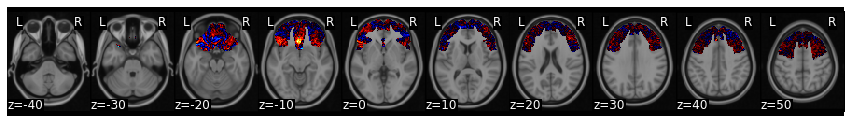

In [96]:
#visualize the first Brain_Data image in pickled_Data
pickled_data[0].plot()
#looks good!

In [26]:
print ("running")
print('really')
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:2],'conditions_nos',
    behavioral_design=sst_1_behavdesign_correct_conditions,
    out_folder = ml_data_folderpath + "/SST/",
    out_file_suffix = '_correct_cond_pfc',
    sst_wt_repo = nonbids_data_path + "fMRI/fx/models/SST/wave1/",
    subj_brain_data_args = {
        'standardize_by_condition':False,
        'mask':mask_pfc
    }
    )

running
really
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions_nos/
DEV011
...../gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions_nos/sub-DEV011/beta_0013.nii


Exception: beta beta_0013.nii does not exist at /gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions_nos/sub-DEV011/beta_0013.nii

In [28]:
print("running")
print('really')
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:6],'conditions_nos',
    behavioral_design=sst_1_behavdesign_correct_conditions,
    out_folder = ml_data_folderpath + "/SST/",
    out_file_suffix = '_correct_cond_pfc',
    sst_wt_repo = nonbids_data_path + "fMRI/fx/models/SST/wave1/",
    subj_brain_data_args = {
        'standardize_by_condition':False,
        'mask':mask_pfc
    }
)

running
really
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries_nos/
DEV011
...............................................................................................................verified that all expected betas exist! Processing...retrieving a mask from the first image in the series beta_0003.nii
...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
          onset  duration  trial_type subject   wave           beta  \
1794    2.75834   0.64209  correct-go  DEV011  wave1  beta_0003.nii   
1796    5.51390   0.56936  correct-go  DEV011  wave1  beta_0005.nii   
1798    9.02224   0.46994  correct-go  DEV011  wave1  beta_0007.nii   
1800   12.52780   0.40205  correct-go  DEV011  wave1  beta_0009.nii   
1802   15.90975   0.44627  correct-go  DEV011  wave1  beta_0011.nii   
...         ...       ...         ...     ...    ...            ...   
2

converting to nifti and fdata
           onset  duration    trial_type subject   wave           beta  \
15104    0.00000   0.66403    correct-go  DEV064  wave1  beta_0001.nii   
15108    6.38890   0.60191    correct-go  DEV064  wave1  beta_0005.nii   
15112   15.65280   0.50451    correct-go  DEV064  wave1  beta_0009.nii   
15114   20.53475   0.39299    correct-go  DEV064  wave1  beta_0011.nii   
15116   23.35212   0.45068    correct-go  DEV064  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
15348  404.11667   0.52668    correct-go  DEV064  wave1  beta_0245.nii   
15350  407.24723   0.59783    correct-go  DEV064  wave1  beta_0247.nii   
15354  412.44516   0.72932    correct-go  DEV064  wave1  beta_0251.nii   
15356  416.20072   2.51110  correct-stop  DEV064  wave1  beta_0253.nii   
15358  421.21182   0.81115    correct-go  DEV064  wave1  beta_0255.nii   

      prev_trial_type post_stop_correct_go_subtype  
15104             NaN       

In [28]:
print ("running")
print('really')
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:30],'betaseries_nos',
    behavioral_design=sst_1_behavdesign_correct_conditions,
    out_folder = ml_data_folderpath + "/SST/",
    out_file_suffix = '_correct_cond_pfc',
    sst_wt_repo = nonbids_data_path + "fMRI/fx/models/SST/wave1/",
    subj_brain_data_args = {
        'standardize_by_condition':True,
        'mask':mask_pfc
    }
)

running
really
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries_nos/
DEV011
...............................................................................................................verified that all expected betas exist! Processing...retrieving a mask from the first image in the series beta_0003.nii
...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.9874082
35.216568
-0.025306031
1.0137758
          onset  duration  trial_type subject   wave           beta  \
1794    2.75834   0.64209  correct-go  DEV011  wave1  beta_0003.nii   
1796    5.51390   0.56936  correct-go  DEV011  wave1  beta_0005.nii   
1798    9.02224   0.46994  correct-go  DEV011  wave1  beta_0007.nii   
1800   12.52780   0.40205  correct-go  DEV011  wave1  beta_0009.nii   
1802   15.90975   0.44627  correct-go  DEV011  wave1  beta_0011.nii   
...         ...       ...   

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.4502941
21.833902
0.037751976
1.0412676
          onset  duration    trial_type subject   wave           beta  \
4098    2.75834   0.75769    correct-go  DEV020  wave1  beta_0003.nii   
4100    5.51390   0.53414    correct-go  DEV020  wave1  beta_0005.nii   
4102    9.02224   0.60132    correct-go  DEV020  wave1  beta_0007.nii   
4104   12.52780   0.62845    correct-go  DEV020  wave1  beta_0009.nii   
4106   15.90975   0.63436    correct-go  DEV020  wave1  beta_0011.nii   
...         ...       ...           ...     ...    ...            ...   
4340  401.49167   2.00556  correct-stop  DEV020  wave1  beta_0245.nii   
4342  403.99723   0.60572    correct-go  DEV020  wave1  beta_0247.nii   
4344  407.31460   0.57269    correct-go  DEV020  wave1  beta_0249.nii   
4346  410.82016   0.48897    correct-go  DEV020  wave1  beta_0251.

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-4.1844344
24.49937
-0.010184274
1.0110923
           onset  duration    trial_type subject   wave           beta  \
11008    0.00000   0.96259    correct-go  DEV047  wave1  beta_0001.nii   
11012    6.38890   0.58196    correct-go  DEV047  wave1  beta_0005.nii   
11016   15.65280   0.60373    correct-go  DEV047  wave1  beta_0009.nii   
11018   20.53475   0.56612    correct-go  DEV047  wave1  beta_0011.nii   
11020   23.35212   0.63492    correct-go  DEV047  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
11252  404.11667   0.50827    correct-go  DEV047  wave1  beta_0245.nii   
11254  407.24723   0.55187    correct-go  DEV047  wave1  beta_0247.nii   
11256  409.68960   2.00556  correct-stop  DEV047  wave1  beta_0249.nii   
11258  412.44516   0.54573    correct-go  DEV047  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.3755547
18.904978
-0.011645912
0.9638973
           onset  duration  trial_type subject   wave           beta  \
14850    2.75834   0.69411  correct-go  DEV063  wave1  beta_0003.nii   
14852    5.51390   0.55317  correct-go  DEV063  wave1  beta_0005.nii   
14854    9.02224   0.51317  correct-go  DEV063  wave1  beta_0007.nii   
14856   12.52780   0.45418  correct-go  DEV063  wave1  beta_0009.nii   
14858   15.90975   0.45353  correct-go  DEV063  wave1  beta_0011.nii   
...          ...       ...         ...     ...    ...            ...   
15090  398.86111   0.55657  correct-go  DEV063  wave1  beta_0243.nii   
15094  403.99723   0.53123  correct-go  DEV063  wave1  beta_0247.nii   
15096  407.31460   0.44475  correct-go  DEV063  wave1  beta_0249.nii   
15098  410.82016   0.51348  correct-go  DEV063  wave1  beta_0251.nii   
151

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.7449762
17.899967
0.022723367
1.0455954
           onset  duration    trial_type subject   wave           beta  \
15104    0.00000   0.66403    correct-go  DEV064  wave1  beta_0001.nii   
15108    6.38890   0.60191    correct-go  DEV064  wave1  beta_0005.nii   
15112   15.65280   0.50451    correct-go  DEV064  wave1  beta_0009.nii   
15114   20.53475   0.39299    correct-go  DEV064  wave1  beta_0011.nii   
15116   23.35212   0.45068    correct-go  DEV064  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
15348  404.11667   0.52668    correct-go  DEV064  wave1  beta_0245.nii   
15350  407.24723   0.59783    correct-go  DEV064  wave1  beta_0247.nii   
15354  412.44516   0.72932    correct-go  DEV064  wave1  beta_0251.nii   
15356  416.20072   2.51110  correct-stop  DEV064  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.13488035
59.58149
0.013791005
0.9816627
           onset  duration    trial_type subject   wave           beta  \
15878   11.77224   2.00556  correct-stop  DEV067  wave1  beta_0007.nii   
15882   20.53475   0.98298    correct-go  DEV067  wave1  beta_0011.nii   
15886   25.98407   0.00262    correct-go  DEV067  wave1  beta_0015.nii   
15888   28.92644   0.81914    correct-go  DEV067  wave1  beta_0017.nii   
15890   31.43061   0.77348    correct-go  DEV067  wave1  beta_0019.nii   
...          ...       ...           ...     ...    ...            ...   
16116  404.11667   0.82027    correct-go  DEV067  wave1  beta_0245.nii   
16118  407.24723   0.97949    correct-go  DEV067  wave1  beta_0247.nii   
16120  409.68960   2.00556  correct-stop  DEV067  wave1  beta_0249.nii   
16124  416.20072   2.51110  correct-stop  DEV067  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.006535
13.087223
0.0025046826
0.98781204
           onset  duration    trial_type subject   wave           beta  \
17920    0.00000   2.25834  correct-stop  DEV075  wave1  beta_0001.nii   
17922    2.75834   0.94359    correct-go  DEV075  wave1  beta_0003.nii   
17924    5.51390   0.59314    correct-go  DEV075  wave1  beta_0005.nii   
17926    9.02224   0.46077    correct-go  DEV075  wave1  beta_0007.nii   
17928   12.52780   0.53969    correct-go  DEV075  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
18162  398.86111   0.51157    correct-go  DEV075  wave1  beta_0243.nii   
18166  403.99723   0.50196    correct-go  DEV075  wave1  beta_0247.nii   
18168  407.31460   0.42222    correct-go  DEV075  wave1  beta_0249.nii   
18170  410.82016   0.44291    correct-go  DEV075  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.7582148
20.809038
0.008756983
1.0767316
           onset  duration    trial_type subject   wave           beta  \
21248    0.00000   2.25834  correct-stop  DEV088  wave1  beta_0001.nii   
21250    2.75834   0.57672    correct-go  DEV088  wave1  beta_0003.nii   
21252    5.51390   0.62120    correct-go  DEV088  wave1  beta_0005.nii   
21254    9.02224   0.60448    correct-go  DEV088  wave1  beta_0007.nii   
21256   12.52780   0.53131    correct-go  DEV088  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
21490  398.86111   0.51822    correct-go  DEV088  wave1  beta_0243.nii   
21494  403.99723   0.83383    correct-go  DEV088  wave1  beta_0247.nii   
21496  407.31460   0.68420    correct-go  DEV088  wave1  beta_0249.nii   
21498  410.82016   0.49529    correct-go  DEV088  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.094875865
11.725862
-5.890428e-11
1.0
           onset  duration  trial_type subject   wave           beta  \
22532    6.38890   0.00132  correct-go  DEV094  wave1  beta_0005.nii   
22536   15.65280   0.54894  correct-go  DEV094  wave1  beta_0009.nii   
22538   20.53475   0.49550  correct-go  DEV094  wave1  beta_0011.nii   
22540   23.35212   0.44689  correct-go  DEV094  wave1  beta_0013.nii   
22542   25.98407   0.53667  correct-go  DEV094  wave1  beta_0015.nii   
...          ...       ...         ...     ...    ...            ...   
22770  400.61111   0.62958  correct-go  DEV094  wave1  beta_0243.nii   
22772  404.11667   0.42448  correct-go  DEV094  wave1  beta_0245.nii   
22774  407.24723   0.64481  correct-go  DEV094  wave1  beta_0247.nii   
22778  412.44516   0.58726  correct-go  DEV094  wave1  beta_0251.nii   
22782 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.0968084
13.606431
-0.022399247
1.0040638
           onset  duration    trial_type subject   wave           beta  \
23296    0.00000   0.50199    correct-go  DEV097  wave1  beta_0001.nii   
23300    6.38890   0.00171    correct-go  DEV097  wave1  beta_0005.nii   
23304   15.65280   0.46959    correct-go  DEV097  wave1  beta_0009.nii   
23306   20.53475   0.40862    correct-go  DEV097  wave1  beta_0011.nii   
23308   23.35212   0.49035    correct-go  DEV097  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
23542  407.24723   0.43663    correct-go  DEV097  wave1  beta_0247.nii   
23544  409.68960   2.00556  correct-stop  DEV097  wave1  beta_0249.nii   
23546  412.44516   0.63378    correct-go  DEV097  wave1  beta_0251.nii   
23548  416.20072   2.51110  correct-stop  DEV097  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.48148683
19.117004
-0.012588218
1.0493643
           onset  duration    trial_type subject   wave           beta  \
23810    2.75834   0.87587    correct-go  DEV100  wave1  beta_0003.nii   
23812    5.51390   0.68037    correct-go  DEV100  wave1  beta_0005.nii   
23814    9.02224   0.61405    correct-go  DEV100  wave1  beta_0007.nii   
23816   12.52780   0.59277    correct-go  DEV100  wave1  beta_0009.nii   
23818   15.90975   0.54501    correct-go  DEV100  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
24052  401.49167   2.00556  correct-stop  DEV100  wave1  beta_0245.nii   
24054  403.99723   0.54027    correct-go  DEV100  wave1  beta_0247.nii   
24056  407.31460   0.68665    correct-go  DEV100  wave1  beta_0249.nii   
24058  410.82016   0.76623    correct-go  DEV100  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.1995767
45.69865
-0.050141092
1.0576055
           onset  duration    trial_type subject   wave           beta  \
24324    6.38890   0.95380    correct-go  DEV102  wave1  beta_0005.nii   
24330   20.53475   0.52267    correct-go  DEV102  wave1  beta_0011.nii   
24332   23.35212   1.00374    correct-go  DEV102  wave1  beta_0013.nii   
24334   25.98407   0.59099    correct-go  DEV102  wave1  beta_0015.nii   
24336   28.92644   0.50155    correct-go  DEV102  wave1  beta_0017.nii   
...          ...       ...           ...     ...    ...            ...   
24562  400.61111   0.81409    correct-go  DEV102  wave1  beta_0243.nii   
24564  404.11667   0.77791    correct-go  DEV102  wave1  beta_0245.nii   
24568  409.68960   2.00556  correct-stop  DEV102  wave1  beta_0249.nii   
24570  412.44516   0.94143    correct-go  DEV102  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.0482846
13.349634
0.020448135
1.0346857
           onset  duration    trial_type subject   wave           beta  \
25088    0.00000   2.25834  correct-stop  DEV105  wave1  beta_0001.nii   
25090    2.75834   0.24692    correct-go  DEV105  wave1  beta_0003.nii   
25094    9.02224   0.73690    correct-go  DEV105  wave1  beta_0007.nii   
25096   12.52780   0.90126    correct-go  DEV105  wave1  beta_0009.nii   
25098   15.90975   0.68569    correct-go  DEV105  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
25332  401.49167   2.00556  correct-stop  DEV105  wave1  beta_0245.nii   
25334  403.99723   0.74646    correct-go  DEV105  wave1  beta_0247.nii   
25336  407.31460   0.77564    correct-go  DEV105  wave1  beta_0249.nii   
25338  410.82016   0.76324    correct-go  DEV105  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-2.3372688
21.988825
0.052590646
0.9120877
           onset  duration    trial_type subject   wave           beta  \
25600    0.00000   0.90791    correct-go  DEV107  wave1  beta_0001.nii   
25602    3.00834   2.00556  correct-stop  DEV107  wave1  beta_0003.nii   
25604    6.38890   0.56516    correct-go  DEV107  wave1  beta_0005.nii   
25608   15.65280   0.45421    correct-go  DEV107  wave1  beta_0009.nii   
25610   20.53475   0.38989    correct-go  DEV107  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
25846  407.24723   0.44525    correct-go  DEV107  wave1  beta_0247.nii   
25848  409.68960   2.00556  correct-stop  DEV107  wave1  beta_0249.nii   
25850  412.44516   0.57801    correct-go  DEV107  wave1  beta_0251.nii   
25852  416.20072   2.51110  correct-stop  DEV107  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.0390915
11.313136
-0.0043423036
0.99248487
           onset  duration    trial_type subject   wave           beta  \
26626    2.75834   0.74795    correct-go  DEV111  wave1  beta_0003.nii   
26628    5.51390   0.68338    correct-go  DEV111  wave1  beta_0005.nii   
26630    9.02224   0.77696    correct-go  DEV111  wave1  beta_0007.nii   
26632   12.52780   0.71406    correct-go  DEV111  wave1  beta_0009.nii   
26634   15.90975   0.63424    correct-go  DEV111  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
26864  395.98194   0.85828    correct-go  DEV111  wave1  beta_0241.nii   
26868  401.49167   2.00556  correct-stop  DEV111  wave1  beta_0245.nii   
26874  410.82016   0.82033    correct-go  DEV111  wave1  beta_0251.nii   
26876  414.57572   0.93993    correct-go  DEV111  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.6138635
19.71308
0.0071680374
1.010303
           onset  duration    trial_type subject   wave           beta  \
27138    2.75834   0.71787    correct-go  DEV113  wave1  beta_0003.nii   
27140    5.51390   0.50024    correct-go  DEV113  wave1  beta_0005.nii   
27142    9.02224   0.54990    correct-go  DEV113  wave1  beta_0007.nii   
27144   12.52780   0.53401    correct-go  DEV113  wave1  beta_0009.nii   
27146   15.90975   0.49869    correct-go  DEV113  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
27382  403.99723   0.65956    correct-go  DEV113  wave1  beta_0247.nii   
27384  407.31460   0.71876    correct-go  DEV113  wave1  beta_0249.nii   
27386  410.82016   0.71248    correct-go  DEV113  wave1  beta_0251.nii   
27388  414.57572   0.89165    correct-go  DEV113  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.382842
18.994383
-0.03686587
1.3375076
           onset  duration    trial_type subject   wave           beta  \
27392    0.00000   0.88479    correct-go  DEV114  wave1  beta_0001.nii   
27396    6.38890   0.44063    correct-go  DEV114  wave1  beta_0005.nii   
27400   15.65280   0.59958    correct-go  DEV114  wave1  beta_0009.nii   
27402   20.53475   0.39786    correct-go  DEV114  wave1  beta_0011.nii   
27404   23.35212   0.39660    correct-go  DEV114  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
27636  404.11667   0.52210    correct-go  DEV114  wave1  beta_0245.nii   
27638  407.24723   0.42238    correct-go  DEV114  wave1  beta_0247.nii   
27642  412.44516   0.64335    correct-go  DEV114  wave1  beta_0251.nii   
27644  416.20072   2.51110  correct-stop  DEV114  wave1  

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.30932564
18.109114
-0.015310037
0.94539404
           onset  duration    trial_type subject   wave           beta  \
27904    0.00000   0.64358    correct-go  DEV116  wave1  beta_0001.nii   
27908    6.38890   0.47278    correct-go  DEV116  wave1  beta_0005.nii   
27912   15.65280   0.52429    correct-go  DEV116  wave1  beta_0009.nii   
27914   20.53475   0.42468    correct-go  DEV116  wave1  beta_0011.nii   
27916   23.35212   0.37490    correct-go  DEV116  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
28150  407.24723   0.49599    correct-go  DEV116  wave1  beta_0247.nii   
28152  409.68960   2.00556  correct-stop  DEV116  wave1  beta_0249.nii   
28154  412.44516   0.67144    correct-go  DEV116  wave1  beta_0251.nii   
28156  416.20072   2.51110  correct-stop  DEV116  wa

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.67950636
14.049025
0.050775263
0.99599284
           onset  duration    trial_type subject   wave           beta  \
28416    0.00000   2.25834  correct-stop  DEV118  wave1  beta_0001.nii   
28420    5.51390   0.66617    correct-go  DEV118  wave1  beta_0005.nii   
28422    9.02224   0.73077    correct-go  DEV118  wave1  beta_0007.nii   
28424   12.52780   0.70320    correct-go  DEV118  wave1  beta_0009.nii   
28426   15.90975   0.59533    correct-go  DEV118  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
28662  403.99723   0.99881    correct-go  DEV118  wave1  beta_0247.nii   
28664  407.31460   0.71339    correct-go  DEV118  wave1  beta_0249.nii   
28666  410.82016   0.74300    correct-go  DEV118  wave1  beta_0251.nii   
28668  414.57572   0.69948    correct-go  DEV118  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.51434445
14.46002
0.005931444
1.1053315
           onset  duration    trial_type subject   wave           beta  \
28676    6.38890   0.57727    correct-go  DEV119  wave1  beta_0005.nii   
28680   15.65280   0.64270    correct-go  DEV119  wave1  beta_0009.nii   
28682   20.53475   0.55391    correct-go  DEV119  wave1  beta_0011.nii   
28684   23.35212   0.38971    correct-go  DEV119  wave1  beta_0013.nii   
28686   25.98407   0.36722    correct-go  DEV119  wave1  beta_0015.nii   
...          ...       ...           ...     ...    ...            ...   
28916  404.11667   0.50351    correct-go  DEV119  wave1  beta_0245.nii   
28918  407.24723   0.71874    correct-go  DEV119  wave1  beta_0247.nii   
28922  412.44516   0.70710    correct-go  DEV119  wave1  beta_0251.nii   
28924  416.20072   2.51110  correct-stop  DEV119  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-3.6610012
24.566036
0.2117409
0.91754407
           onset  duration  trial_type subject   wave           beta  \
32772    5.51390   0.40431  correct-go  DEV135  wave1  beta_0005.nii   
32774    9.02224   0.43539  correct-go  DEV135  wave1  beta_0007.nii   
32776   12.52780   0.39240  correct-go  DEV135  wave1  beta_0009.nii   
32778   15.90975   0.46770  correct-go  DEV135  wave1  beta_0011.nii   
32780   18.35212   0.41383  correct-go  DEV135  wave1  beta_0013.nii   
...          ...       ...         ...     ...    ...            ...   
33010  398.86111   0.39121  correct-go  DEV135  wave1  beta_0243.nii   
33014  403.99723   0.48847  correct-go  DEV135  wave1  beta_0247.nii   
33016  407.31460   0.62746  correct-go  DEV135  wave1  beta_0249.nii   
33018  410.82016   0.53523  correct-go  DEV135  wave1  beta_0251.nii   
3302

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.423012
17.992792
-0.055264935
1.1677489
           onset  duration  trial_type subject   wave           beta  \
33284    5.51390   0.52897  correct-go  DEV138  wave1  beta_0005.nii   
33286    9.02224   0.63922  correct-go  DEV138  wave1  beta_0007.nii   
33288   12.52780   0.62808  correct-go  DEV138  wave1  beta_0009.nii   
33290   15.90975   0.54256  correct-go  DEV138  wave1  beta_0011.nii   
33292   18.35212   0.51150  correct-go  DEV138  wave1  beta_0013.nii   
...          ...       ...         ...     ...    ...            ...   
33522  398.86111   0.45453  correct-go  DEV138  wave1  beta_0243.nii   
33526  403.99723   0.93126  correct-go  DEV138  wave1  beta_0247.nii   
33528  407.31460   0.58821  correct-go  DEV138  wave1  beta_0249.nii   
33530  410.82016   0.43210  correct-go  DEV138  wave1  beta_0251.nii   
3353

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.9130762
14.4948
0.023464454
1.0123452
           onset  duration    trial_type subject   wave           beta  \
34050    2.75834   0.60594    correct-go  DEV141  wave1  beta_0003.nii   
34052    5.51390   0.40100    correct-go  DEV141  wave1  beta_0005.nii   
34054    9.02224   0.45223    correct-go  DEV141  wave1  beta_0007.nii   
34056   12.52780   0.44496    correct-go  DEV141  wave1  beta_0009.nii   
34058   15.90975   0.41975    correct-go  DEV141  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
34294  403.99723   0.49383    correct-go  DEV141  wave1  beta_0247.nii   
34296  407.31460   0.48169    correct-go  DEV141  wave1  beta_0249.nii   
34298  410.82016   0.48638    correct-go  DEV141  wave1  beta_0251.nii   
34300  414.57572   0.52030    correct-go  DEV141  wave1  b

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.4928561
15.124091
0.023015773
1.0644697
           onset  duration    trial_type subject   wave           beta  \
34560    0.00000   0.50014    correct-go  DEV144  wave1  beta_0001.nii   
34564    6.38890   0.39365    correct-go  DEV144  wave1  beta_0005.nii   
34568   15.65280   0.62631    correct-go  DEV144  wave1  beta_0009.nii   
34570   20.53475   0.42627    correct-go  DEV144  wave1  beta_0011.nii   
34572   23.35212   0.51089    correct-go  DEV144  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
34804  404.11667   0.64689    correct-go  DEV144  wave1  beta_0245.nii   
34806  407.24723   0.61365    correct-go  DEV144  wave1  beta_0247.nii   
34808  409.68960   2.00556  correct-stop  DEV144  wave1  beta_0249.nii   
34810  412.44516   0.47414    correct-go  DEV144  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-4.2417617
33.92006
-0.08927723
1.0687797
           onset  duration    trial_type subject   wave           beta  \
34818    2.75834   0.61486    correct-go  DEV145  wave1  beta_0003.nii   
34820    5.51390   0.37433    correct-go  DEV145  wave1  beta_0005.nii   
34822    9.02224   0.57750    correct-go  DEV145  wave1  beta_0007.nii   
34824   12.52780   0.49848    correct-go  DEV145  wave1  beta_0009.nii   
34826   15.90975   0.46570    correct-go  DEV145  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
35062  403.99723   0.54751    correct-go  DEV145  wave1  beta_0247.nii   
35064  407.31460   0.50091    correct-go  DEV145  wave1  beta_0249.nii   
35066  410.82016   0.48216    correct-go  DEV145  wave1  beta_0251.nii   
35068  414.57572   0.48781    correct-go  DEV145  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.77438354
16.25711
-0.019952748
1.0530322
           onset  duration    trial_type subject   wave           beta  \
36864    0.00000   2.25834  correct-stop  DEV155  wave1  beta_0001.nii   
36866    2.75834   0.59172    correct-go  DEV155  wave1  beta_0003.nii   
36868    5.51390   0.53652    correct-go  DEV155  wave1  beta_0005.nii   
36870    9.02224   0.46613    correct-go  DEV155  wave1  beta_0007.nii   
36872   12.52780   0.40357    correct-go  DEV155  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
37106  398.86111   0.53596    correct-go  DEV155  wave1  beta_0243.nii   
37110  403.99723   0.47036    correct-go  DEV155  wave1  beta_0247.nii   
37112  407.31460   0.51225    correct-go  DEV155  wave1  beta_0249.nii   
37114  410.82016   0.45032    correct-go  DEV155  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.35816506
21.430367
-0.044008005
1.0752583
           onset  duration  trial_type subject   wave           beta  \
37128   15.65280   0.69963  correct-go  DEV156  wave1  beta_0009.nii   
37130   20.53475   0.83173  correct-go  DEV156  wave1  beta_0011.nii   
37132   23.35212   0.63388  correct-go  DEV156  wave1  beta_0013.nii   
37134   25.98407   0.72617  correct-go  DEV156  wave1  beta_0015.nii   
37138   31.43061   0.61134  correct-go  DEV156  wave1  beta_0019.nii   
...          ...       ...         ...     ...    ...            ...   
37360  396.23194   0.60437  correct-go  DEV156  wave1  beta_0241.nii   
37362  400.61111   0.67469  correct-go  DEV156  wave1  beta_0243.nii   
37364  404.11667   0.63512  correct-go  DEV156  wave1  beta_0245.nii   
37366  407.24723   0.61030  correct-go  DEV156  wave1  beta_0247.nii   
3

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.62934065
11.333877
-0.08073227
1.2017245
           onset  duration  trial_type subject   wave           beta  \
37376    0.00000   0.87197  correct-go  DEV157  wave1  beta_0001.nii   
37380    6.38890   0.08329  correct-go  DEV157  wave1  beta_0005.nii   
37384   15.65280   0.59839  correct-go  DEV157  wave1  beta_0009.nii   
37386   20.53475   0.46574  correct-go  DEV157  wave1  beta_0011.nii   
37388   23.35212   0.34208  correct-go  DEV157  wave1  beta_0013.nii   
...          ...       ...         ...     ...    ...            ...   
37618  400.61111   0.43916  correct-go  DEV157  wave1  beta_0243.nii   
37620  404.11667   0.72024  correct-go  DEV157  wave1  beta_0245.nii   
37622  407.24723   0.43989  correct-go  DEV157  wave1  beta_0247.nii   
37626  412.44516   0.00170  correct-go  DEV157  wave1  beta_0251.nii   
376

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.93094045
16.302166
-0.109055065
1.0795051
           onset  duration  trial_type subject   wave           beta  \
37634    2.75834   0.90707  correct-go  DEV158  wave1  beta_0003.nii   
37636    5.51390   0.86909  correct-go  DEV158  wave1  beta_0005.nii   
37638    9.02224   0.38633  correct-go  DEV158  wave1  beta_0007.nii   
37640   12.52780   0.47927  correct-go  DEV158  wave1  beta_0009.nii   
37642   15.90975   0.46463  correct-go  DEV158  wave1  beta_0011.nii   
...          ...       ...         ...     ...    ...            ...   
37874  398.86111   0.00117  correct-go  DEV158  wave1  beta_0243.nii   
37878  403.99723   0.00168  correct-go  DEV158  wave1  beta_0247.nii   
37880  407.31460   0.00163  correct-go  DEV158  wave1  beta_0249.nii   
37882  410.82016   0.00154  correct-go  DEV158  wave1  beta_0251.nii   
3

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.61642134
11.586989
-0.0014113513
1.0094408
           onset  duration    trial_type subject   wave           beta  \
37890    3.00834   2.00556  correct-stop  DEV159  wave1  beta_0003.nii   
37892    6.38890   0.66374    correct-go  DEV159  wave1  beta_0005.nii   
37896   15.65280   0.50080    correct-go  DEV159  wave1  beta_0009.nii   
37898   20.53475   0.66674    correct-go  DEV159  wave1  beta_0011.nii   
37900   23.35212   0.60491    correct-go  DEV159  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
38132  404.11667   0.49857    correct-go  DEV159  wave1  beta_0245.nii   
38134  407.24723   0.49633    correct-go  DEV159  wave1  beta_0247.nii   
38138  412.44516   0.66841    correct-go  DEV159  wave1  beta_0251.nii   
38140  416.20072   2.51110  correct-stop  DEV159  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:574: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/Brain_Data_betaseries_nos_30subs_correct_cond_pfc.pkl


### Standardize by condition

In [29]:
print ("running")
print('really')
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:2],'betaseries_nos',
    behavioral_design=sst_1_behavdesign_correct_conditions,
    out_folder = ml_data_folderpath + "/SST/",
    out_file_suffix = '_correct_cond_pfc_condstd',
    sst_wt_repo = nonbids_data_path + "fMRI/fx/models/SST/wave1/",
    subj_brain_data_args = {
        'standardize_by_condition':True,
        'mask':mask_pfc
    }
    )

running
really
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries_nos/
DEV011
...............................................................................................................verified that all expected betas exist! Processing...retrieving a mask from the first image in the series beta_0003.nii
...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.7600034
87.18561
-0.008000759
1.0252229
          onset  duration  trial_type subject   wave           beta  \
1794    2.75834   0.64209  correct-go  DEV011  wave1  beta_0003.nii   
1796    5.51390   0.56936  correct-go  DEV011  wave1  beta_0005.nii   
1798    9.02224   0.46994  correct-go  DEV011  wave1  beta_0007.nii   
1800   12.52780   0.40205  correct-go  DEV011  wave1  beta_0009.nii   
1802   15.90975   0.44627  correct-go  DEV011  wave1  beta_0011.nii   
...         ...       ...    

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.4142033
101.85565
0.008478793
1.017896
          onset  duration    trial_type subject   wave           beta  \
4098    2.75834   0.75769    correct-go  DEV020  wave1  beta_0003.nii   
4100    5.51390   0.53414    correct-go  DEV020  wave1  beta_0005.nii   
4102    9.02224   0.60132    correct-go  DEV020  wave1  beta_0007.nii   
4104   12.52780   0.62845    correct-go  DEV020  wave1  beta_0009.nii   
4106   15.90975   0.63436    correct-go  DEV020  wave1  beta_0011.nii   
...         ...       ...           ...     ...    ...            ...   
4340  401.49167   2.00556  correct-stop  DEV020  wave1  beta_0245.nii   
4342  403.99723   0.60572    correct-go  DEV020  wave1  beta_0247.nii   
4344  407.31460   0.57269    correct-go  DEV020  wave1  beta_0249.nii   
4346  410.82016   0.48897    correct-go  DEV020  wave1  beta_0251.n

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


In [33]:
print ("running")
print('really')
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:6],'betaseries_nos',
    behavioral_design=sst_1_behavdesign_correct_conditions,
    out_folder = ml_data_folderpath + "/SST/",
    out_file_suffix = '_correct_cond_pfc_condstd',
    sst_wt_repo = nonbids_data_path + "fMRI/fx/models/SST/wave1/",
    subj_brain_data_args = {
        'standardize_by_condition':True,
        'mask':mask_pfc
    }
    )

running
really
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries_nos/
DEV011
...............................................................................................................verified that all expected betas exist! Processing...retrieving a mask from the first image in the series beta_0003.nii
...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.7600034
87.18561
-0.008000759
1.0252229
          onset  duration  trial_type subject   wave           beta  \
1794    2.75834   0.64209  correct-go  DEV011  wave1  beta_0003.nii   
1796    5.51390   0.56936  correct-go  DEV011  wave1  beta_0005.nii   
1798    9.02224   0.46994  correct-go  DEV011  wave1  beta_0007.nii   
1800   12.52780   0.40205  correct-go  DEV011  wave1  beta_0009.nii   
1802   15.90975   0.44627  correct-go  DEV011  wave1  beta_0011.nii   
...         ...       ...    

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.4142033
101.85565
0.008478793
1.017896
          onset  duration    trial_type subject   wave           beta  \
4098    2.75834   0.75769    correct-go  DEV020  wave1  beta_0003.nii   
4100    5.51390   0.53414    correct-go  DEV020  wave1  beta_0005.nii   
4102    9.02224   0.60132    correct-go  DEV020  wave1  beta_0007.nii   
4104   12.52780   0.62845    correct-go  DEV020  wave1  beta_0009.nii   
4106   15.90975   0.63436    correct-go  DEV020  wave1  beta_0011.nii   
...         ...       ...           ...     ...    ...            ...   
4340  401.49167   2.00556  correct-stop  DEV020  wave1  beta_0245.nii   
4342  403.99723   0.60572    correct-go  DEV020  wave1  beta_0247.nii   
4344  407.31460   0.57269    correct-go  DEV020  wave1  beta_0249.nii   
4346  410.82016   0.48897    correct-go  DEV020  wave1  beta_0251.n

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-2.8227136
107.47226
-0.0020305365
1.0074891
           onset  duration    trial_type subject   wave           beta  \
11008    0.00000   0.96259    correct-go  DEV047  wave1  beta_0001.nii   
11012    6.38890   0.58196    correct-go  DEV047  wave1  beta_0005.nii   
11016   15.65280   0.60373    correct-go  DEV047  wave1  beta_0009.nii   
11018   20.53475   0.56612    correct-go  DEV047  wave1  beta_0011.nii   
11020   23.35212   0.63492    correct-go  DEV047  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
11252  404.11667   0.50827    correct-go  DEV047  wave1  beta_0245.nii   
11254  407.24723   0.55187    correct-go  DEV047  wave1  beta_0247.nii   
11256  409.68960   2.00556  correct-stop  DEV047  wave1  beta_0249.nii   
11258  412.44516   0.54573    correct-go  DEV047  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.2249689
70.18031
-0.0034117177
0.9705163
           onset  duration  trial_type subject   wave           beta  \
14850    2.75834   0.69411  correct-go  DEV063  wave1  beta_0003.nii   
14852    5.51390   0.55317  correct-go  DEV063  wave1  beta_0005.nii   
14854    9.02224   0.51317  correct-go  DEV063  wave1  beta_0007.nii   
14856   12.52780   0.45418  correct-go  DEV063  wave1  beta_0009.nii   
14858   15.90975   0.45353  correct-go  DEV063  wave1  beta_0011.nii   
...          ...       ...         ...     ...    ...            ...   
15090  398.86111   0.55657  correct-go  DEV063  wave1  beta_0243.nii   
15094  403.99723   0.53123  correct-go  DEV063  wave1  beta_0247.nii   
15096  407.31460   0.44475  correct-go  DEV063  wave1  beta_0249.nii   
15098  410.82016   0.51348  correct-go  DEV063  wave1  beta_0251.nii   
151

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.7751084
79.81952
0.0043606246
1.0241463
           onset  duration    trial_type subject   wave           beta  \
15104    0.00000   0.66403    correct-go  DEV064  wave1  beta_0001.nii   
15108    6.38890   0.60191    correct-go  DEV064  wave1  beta_0005.nii   
15112   15.65280   0.50451    correct-go  DEV064  wave1  beta_0009.nii   
15114   20.53475   0.39299    correct-go  DEV064  wave1  beta_0011.nii   
15116   23.35212   0.45068    correct-go  DEV064  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
15348  404.11667   0.52668    correct-go  DEV064  wave1  beta_0245.nii   
15350  407.24723   0.59783    correct-go  DEV064  wave1  beta_0247.nii   
15354  412.44516   0.72932    correct-go  DEV064  wave1  beta_0251.nii   
15356  416.20072   2.51110  correct-stop  DEV064  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.10657946
185.80064
0.0056955614
1.0433391
           onset  duration    trial_type subject   wave           beta  \
15878   11.77224   2.00556  correct-stop  DEV067  wave1  beta_0007.nii   
15882   20.53475   0.98298    correct-go  DEV067  wave1  beta_0011.nii   
15886   25.98407   0.00262    correct-go  DEV067  wave1  beta_0015.nii   
15888   28.92644   0.81914    correct-go  DEV067  wave1  beta_0017.nii   
15890   31.43061   0.77348    correct-go  DEV067  wave1  beta_0019.nii   
...          ...       ...           ...     ...    ...            ...   
16116  404.11667   0.82027    correct-go  DEV067  wave1  beta_0245.nii   
16118  407.24723   0.97949    correct-go  DEV067  wave1  beta_0247.nii   
16120  409.68960   2.00556  correct-stop  DEV067  wave1  beta_0249.nii   
16124  416.20072   2.51110  correct-stop  DEV067  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


In [30]:
print ("running")
print('really')
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:30],'betaseries_nos',
    behavioral_design=sst_1_behavdesign_correct_conditions,
    out_folder = ml_data_folderpath + "/SST/",
    out_file_suffix = '_correct_cond_pfc_condstd',
    sst_wt_repo = nonbids_data_path + "fMRI/fx/models/SST/wave1/",
    subj_brain_data_args = {
        'standardize_by_condition':True,
        'mask':mask_pfc
    }
    )

running
really
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries_nos/
DEV011
...............................................................................................................verified that all expected betas exist! Processing...retrieving a mask from the first image in the series beta_0003.nii
...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.7600034
87.18561
-0.008000759
1.0252229
          onset  duration  trial_type subject   wave           beta  \
1794    2.75834   0.64209  correct-go  DEV011  wave1  beta_0003.nii   
1796    5.51390   0.56936  correct-go  DEV011  wave1  beta_0005.nii   
1798    9.02224   0.46994  correct-go  DEV011  wave1  beta_0007.nii   
1800   12.52780   0.40205  correct-go  DEV011  wave1  beta_0009.nii   
1802   15.90975   0.44627  correct-go  DEV011  wave1  beta_0011.nii   
...         ...       ...    

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.4142033
101.85565
0.008478793
1.017896
          onset  duration    trial_type subject   wave           beta  \
4098    2.75834   0.75769    correct-go  DEV020  wave1  beta_0003.nii   
4100    5.51390   0.53414    correct-go  DEV020  wave1  beta_0005.nii   
4102    9.02224   0.60132    correct-go  DEV020  wave1  beta_0007.nii   
4104   12.52780   0.62845    correct-go  DEV020  wave1  beta_0009.nii   
4106   15.90975   0.63436    correct-go  DEV020  wave1  beta_0011.nii   
...         ...       ...           ...     ...    ...            ...   
4340  401.49167   2.00556  correct-stop  DEV020  wave1  beta_0245.nii   
4342  403.99723   0.60572    correct-go  DEV020  wave1  beta_0247.nii   
4344  407.31460   0.57269    correct-go  DEV020  wave1  beta_0249.nii   
4346  410.82016   0.48897    correct-go  DEV020  wave1  beta_0251.n

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-2.8227136
107.47226
-0.0020305365
1.0074891
           onset  duration    trial_type subject   wave           beta  \
11008    0.00000   0.96259    correct-go  DEV047  wave1  beta_0001.nii   
11012    6.38890   0.58196    correct-go  DEV047  wave1  beta_0005.nii   
11016   15.65280   0.60373    correct-go  DEV047  wave1  beta_0009.nii   
11018   20.53475   0.56612    correct-go  DEV047  wave1  beta_0011.nii   
11020   23.35212   0.63492    correct-go  DEV047  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
11252  404.11667   0.50827    correct-go  DEV047  wave1  beta_0245.nii   
11254  407.24723   0.55187    correct-go  DEV047  wave1  beta_0247.nii   
11256  409.68960   2.00556  correct-stop  DEV047  wave1  beta_0249.nii   
11258  412.44516   0.54573    correct-go  DEV047  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.2249689
70.18031
-0.0034117177
0.9705163
           onset  duration  trial_type subject   wave           beta  \
14850    2.75834   0.69411  correct-go  DEV063  wave1  beta_0003.nii   
14852    5.51390   0.55317  correct-go  DEV063  wave1  beta_0005.nii   
14854    9.02224   0.51317  correct-go  DEV063  wave1  beta_0007.nii   
14856   12.52780   0.45418  correct-go  DEV063  wave1  beta_0009.nii   
14858   15.90975   0.45353  correct-go  DEV063  wave1  beta_0011.nii   
...          ...       ...         ...     ...    ...            ...   
15090  398.86111   0.55657  correct-go  DEV063  wave1  beta_0243.nii   
15094  403.99723   0.53123  correct-go  DEV063  wave1  beta_0247.nii   
15096  407.31460   0.44475  correct-go  DEV063  wave1  beta_0249.nii   
15098  410.82016   0.51348  correct-go  DEV063  wave1  beta_0251.nii   
151

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.7751084
79.81952
0.0043606246
1.0241463
           onset  duration    trial_type subject   wave           beta  \
15104    0.00000   0.66403    correct-go  DEV064  wave1  beta_0001.nii   
15108    6.38890   0.60191    correct-go  DEV064  wave1  beta_0005.nii   
15112   15.65280   0.50451    correct-go  DEV064  wave1  beta_0009.nii   
15114   20.53475   0.39299    correct-go  DEV064  wave1  beta_0011.nii   
15116   23.35212   0.45068    correct-go  DEV064  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
15348  404.11667   0.52668    correct-go  DEV064  wave1  beta_0245.nii   
15350  407.24723   0.59783    correct-go  DEV064  wave1  beta_0247.nii   
15354  412.44516   0.72932    correct-go  DEV064  wave1  beta_0251.nii   
15356  416.20072   2.51110  correct-stop  DEV064  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.10657946
185.80064
0.0056955614
1.0433391
           onset  duration    trial_type subject   wave           beta  \
15878   11.77224   2.00556  correct-stop  DEV067  wave1  beta_0007.nii   
15882   20.53475   0.98298    correct-go  DEV067  wave1  beta_0011.nii   
15886   25.98407   0.00262    correct-go  DEV067  wave1  beta_0015.nii   
15888   28.92644   0.81914    correct-go  DEV067  wave1  beta_0017.nii   
15890   31.43061   0.77348    correct-go  DEV067  wave1  beta_0019.nii   
...          ...       ...           ...     ...    ...            ...   
16116  404.11667   0.82027    correct-go  DEV067  wave1  beta_0245.nii   
16118  407.24723   0.97949    correct-go  DEV067  wave1  beta_0247.nii   
16120  409.68960   2.00556  correct-stop  DEV067  wave1  beta_0249.nii   
16124  416.20072   2.51110  correct-stop  DEV067  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.0668353
59.548637
0.00058645813
1.0018947
           onset  duration    trial_type subject   wave           beta  \
17920    0.00000   2.25834  correct-stop  DEV075  wave1  beta_0001.nii   
17922    2.75834   0.94359    correct-go  DEV075  wave1  beta_0003.nii   
17924    5.51390   0.59314    correct-go  DEV075  wave1  beta_0005.nii   
17926    9.02224   0.46077    correct-go  DEV075  wave1  beta_0007.nii   
17928   12.52780   0.53969    correct-go  DEV075  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
18162  398.86111   0.51157    correct-go  DEV075  wave1  beta_0243.nii   
18166  403.99723   0.50196    correct-go  DEV075  wave1  beta_0247.nii   
18168  407.31460   0.42222    correct-go  DEV075  wave1  beta_0249.nii   
18170  410.82016   0.44291    correct-go  DEV075  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.7491103
105.385254
0.0016571884
1.0933529
           onset  duration    trial_type subject   wave           beta  \
21248    0.00000   2.25834  correct-stop  DEV088  wave1  beta_0001.nii   
21250    2.75834   0.57672    correct-go  DEV088  wave1  beta_0003.nii   
21252    5.51390   0.62120    correct-go  DEV088  wave1  beta_0005.nii   
21254    9.02224   0.60448    correct-go  DEV088  wave1  beta_0007.nii   
21256   12.52780   0.53131    correct-go  DEV088  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
21490  398.86111   0.51822    correct-go  DEV088  wave1  beta_0243.nii   
21494  403.99723   0.83383    correct-go  DEV088  wave1  beta_0247.nii   
21496  407.31460   0.68420    correct-go  DEV088  wave1  beta_0249.nii   
21498  410.82016   0.49529    correct-go  DEV088  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.17597269
58.684628
-2.7976726e-10
1.0
           onset  duration  trial_type subject   wave           beta  \
22532    6.38890   0.00132  correct-go  DEV094  wave1  beta_0005.nii   
22536   15.65280   0.54894  correct-go  DEV094  wave1  beta_0009.nii   
22538   20.53475   0.49550  correct-go  DEV094  wave1  beta_0011.nii   
22540   23.35212   0.44689  correct-go  DEV094  wave1  beta_0013.nii   
22542   25.98407   0.53667  correct-go  DEV094  wave1  beta_0015.nii   
...          ...       ...         ...     ...    ...            ...   
22770  400.61111   0.62958  correct-go  DEV094  wave1  beta_0243.nii   
22772  404.11667   0.42448  correct-go  DEV094  wave1  beta_0245.nii   
22774  407.24723   0.64481  correct-go  DEV094  wave1  beta_0247.nii   
22778  412.44516   0.58726  correct-go  DEV094  wave1  beta_0251.nii   
22782 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.84606147
75.451385
-0.004419162
1.0098394
           onset  duration    trial_type subject   wave           beta  \
23296    0.00000   0.50199    correct-go  DEV097  wave1  beta_0001.nii   
23300    6.38890   0.00171    correct-go  DEV097  wave1  beta_0005.nii   
23304   15.65280   0.46959    correct-go  DEV097  wave1  beta_0009.nii   
23306   20.53475   0.40862    correct-go  DEV097  wave1  beta_0011.nii   
23308   23.35212   0.49035    correct-go  DEV097  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
23542  407.24723   0.43663    correct-go  DEV097  wave1  beta_0247.nii   
23544  409.68960   2.00556  correct-stop  DEV097  wave1  beta_0249.nii   
23546  412.44516   0.63378    correct-go  DEV097  wave1  beta_0251.nii   
23548  416.20072   2.51110  correct-stop  DEV097  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.5111403
75.97639
-0.0034669675
1.0605494
           onset  duration    trial_type subject   wave           beta  \
23810    2.75834   0.87587    correct-go  DEV100  wave1  beta_0003.nii   
23812    5.51390   0.68037    correct-go  DEV100  wave1  beta_0005.nii   
23814    9.02224   0.61405    correct-go  DEV100  wave1  beta_0007.nii   
23816   12.52780   0.59277    correct-go  DEV100  wave1  beta_0009.nii   
23818   15.90975   0.54501    correct-go  DEV100  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
24052  401.49167   2.00556  correct-stop  DEV100  wave1  beta_0245.nii   
24054  403.99723   0.54027    correct-go  DEV100  wave1  beta_0247.nii   
24056  407.31460   0.68665    correct-go  DEV100  wave1  beta_0249.nii   
24058  410.82016   0.76623    correct-go  DEV100  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.115944
187.3221
-0.011719502
1.0690275
           onset  duration    trial_type subject   wave           beta  \
24324    6.38890   0.95380    correct-go  DEV102  wave1  beta_0005.nii   
24330   20.53475   0.52267    correct-go  DEV102  wave1  beta_0011.nii   
24332   23.35212   1.00374    correct-go  DEV102  wave1  beta_0013.nii   
24334   25.98407   0.59099    correct-go  DEV102  wave1  beta_0015.nii   
24336   28.92644   0.50155    correct-go  DEV102  wave1  beta_0017.nii   
...          ...       ...           ...     ...    ...            ...   
24562  400.61111   0.81409    correct-go  DEV102  wave1  beta_0243.nii   
24564  404.11667   0.77791    correct-go  DEV102  wave1  beta_0245.nii   
24568  409.68960   2.00556  correct-stop  DEV102  wave1  beta_0249.nii   
24570  412.44516   0.94143    correct-go  DEV102  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.9195486
61.31023
0.0038575807
1.0270705
           onset  duration    trial_type subject   wave           beta  \
25088    0.00000   2.25834  correct-stop  DEV105  wave1  beta_0001.nii   
25090    2.75834   0.24692    correct-go  DEV105  wave1  beta_0003.nii   
25094    9.02224   0.73690    correct-go  DEV105  wave1  beta_0007.nii   
25096   12.52780   0.90126    correct-go  DEV105  wave1  beta_0009.nii   
25098   15.90975   0.68569    correct-go  DEV105  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
25332  401.49167   2.00556  correct-stop  DEV105  wave1  beta_0245.nii   
25334  403.99723   0.74646    correct-go  DEV105  wave1  beta_0247.nii   
25336  407.31460   0.77564    correct-go  DEV105  wave1  beta_0249.nii   
25338  410.82016   0.76324    correct-go  DEV105  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-2.0869362
116.48693
0.00857379
0.91409904
           onset  duration    trial_type subject   wave           beta  \
25600    0.00000   0.90791    correct-go  DEV107  wave1  beta_0001.nii   
25602    3.00834   2.00556  correct-stop  DEV107  wave1  beta_0003.nii   
25604    6.38890   0.56516    correct-go  DEV107  wave1  beta_0005.nii   
25608   15.65280   0.45421    correct-go  DEV107  wave1  beta_0009.nii   
25610   20.53475   0.38989    correct-go  DEV107  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
25846  407.24723   0.44525    correct-go  DEV107  wave1  beta_0247.nii   
25848  409.68960   2.00556  correct-stop  DEV107  wave1  beta_0249.nii   
25850  412.44516   0.57801    correct-go  DEV107  wave1  beta_0251.nii   
25852  416.20072   2.51110  correct-stop  DEV107  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.0937687
65.885376
-0.0009056335
0.98619306
           onset  duration    trial_type subject   wave           beta  \
26626    2.75834   0.74795    correct-go  DEV111  wave1  beta_0003.nii   
26628    5.51390   0.68338    correct-go  DEV111  wave1  beta_0005.nii   
26630    9.02224   0.77696    correct-go  DEV111  wave1  beta_0007.nii   
26632   12.52780   0.71406    correct-go  DEV111  wave1  beta_0009.nii   
26634   15.90975   0.63424    correct-go  DEV111  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
26864  395.98194   0.85828    correct-go  DEV111  wave1  beta_0241.nii   
26868  401.49167   2.00556  correct-stop  DEV111  wave1  beta_0245.nii   
26874  410.82016   0.82033    correct-go  DEV111  wave1  beta_0251.nii   
26876  414.57572   0.93993    correct-go  DEV111  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.3924859
79.18518
0.0014724007
1.0034574
           onset  duration    trial_type subject   wave           beta  \
27138    2.75834   0.71787    correct-go  DEV113  wave1  beta_0003.nii   
27140    5.51390   0.50024    correct-go  DEV113  wave1  beta_0005.nii   
27142    9.02224   0.54990    correct-go  DEV113  wave1  beta_0007.nii   
27144   12.52780   0.53401    correct-go  DEV113  wave1  beta_0009.nii   
27146   15.90975   0.49869    correct-go  DEV113  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
27382  403.99723   0.65956    correct-go  DEV113  wave1  beta_0247.nii   
27384  407.31460   0.71876    correct-go  DEV113  wave1  beta_0249.nii   
27386  410.82016   0.71248    correct-go  DEV113  wave1  beta_0251.nii   
27388  414.57572   0.89165    correct-go  DEV113  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.249627
92.52032
-0.007524577
1.3097954
           onset  duration    trial_type subject   wave           beta  \
27392    0.00000   0.88479    correct-go  DEV114  wave1  beta_0001.nii   
27396    6.38890   0.44063    correct-go  DEV114  wave1  beta_0005.nii   
27400   15.65280   0.59958    correct-go  DEV114  wave1  beta_0009.nii   
27402   20.53475   0.39786    correct-go  DEV114  wave1  beta_0011.nii   
27404   23.35212   0.39660    correct-go  DEV114  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
27636  404.11667   0.52210    correct-go  DEV114  wave1  beta_0245.nii   
27638  407.24723   0.42238    correct-go  DEV114  wave1  beta_0247.nii   
27642  412.44516   0.64335    correct-go  DEV114  wave1  beta_0251.nii   
27644  416.20072   2.51110  correct-stop  DEV114  wave1  

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.8317653
114.14684
-0.0030663654
0.958969
           onset  duration    trial_type subject   wave           beta  \
27904    0.00000   0.64358    correct-go  DEV116  wave1  beta_0001.nii   
27908    6.38890   0.47278    correct-go  DEV116  wave1  beta_0005.nii   
27912   15.65280   0.52429    correct-go  DEV116  wave1  beta_0009.nii   
27914   20.53475   0.42468    correct-go  DEV116  wave1  beta_0011.nii   
27916   23.35212   0.37490    correct-go  DEV116  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
28150  407.24723   0.49599    correct-go  DEV116  wave1  beta_0247.nii   
28152  409.68960   2.00556  correct-stop  DEV116  wave1  beta_0249.nii   
28154  412.44516   0.67144    correct-go  DEV116  wave1  beta_0251.nii   
28156  416.20072   2.51110  correct-stop  DEV116  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.6522326
68.493355
0.009939895
1.0065379
           onset  duration    trial_type subject   wave           beta  \
28416    0.00000   2.25834  correct-stop  DEV118  wave1  beta_0001.nii   
28420    5.51390   0.66617    correct-go  DEV118  wave1  beta_0005.nii   
28422    9.02224   0.73077    correct-go  DEV118  wave1  beta_0007.nii   
28424   12.52780   0.70320    correct-go  DEV118  wave1  beta_0009.nii   
28426   15.90975   0.59533    correct-go  DEV118  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
28662  403.99723   0.99881    correct-go  DEV118  wave1  beta_0247.nii   
28664  407.31460   0.71339    correct-go  DEV118  wave1  beta_0249.nii   
28666  410.82016   0.74300    correct-go  DEV118  wave1  beta_0251.nii   
28668  414.57572   0.69948    correct-go  DEV118  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.21556605
74.443405
0.0006740841
1.102889
           onset  duration    trial_type subject   wave           beta  \
28676    6.38890   0.57727    correct-go  DEV119  wave1  beta_0005.nii   
28680   15.65280   0.64270    correct-go  DEV119  wave1  beta_0009.nii   
28682   20.53475   0.55391    correct-go  DEV119  wave1  beta_0011.nii   
28684   23.35212   0.38971    correct-go  DEV119  wave1  beta_0013.nii   
28686   25.98407   0.36722    correct-go  DEV119  wave1  beta_0015.nii   
...          ...       ...           ...     ...    ...            ...   
28916  404.11667   0.50351    correct-go  DEV119  wave1  beta_0245.nii   
28918  407.24723   0.71874    correct-go  DEV119  wave1  beta_0247.nii   
28922  412.44516   0.70710    correct-go  DEV119  wave1  beta_0251.nii   
28924  416.20072   2.51110  correct-stop  DEV119  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-3.7967215
79.30867
0.060034122
0.9433702
           onset  duration  trial_type subject   wave           beta  \
32772    5.51390   0.40431  correct-go  DEV135  wave1  beta_0005.nii   
32774    9.02224   0.43539  correct-go  DEV135  wave1  beta_0007.nii   
32776   12.52780   0.39240  correct-go  DEV135  wave1  beta_0009.nii   
32778   15.90975   0.46770  correct-go  DEV135  wave1  beta_0011.nii   
32780   18.35212   0.41383  correct-go  DEV135  wave1  beta_0013.nii   
...          ...       ...         ...     ...    ...            ...   
33010  398.86111   0.39121  correct-go  DEV135  wave1  beta_0243.nii   
33014  403.99723   0.48847  correct-go  DEV135  wave1  beta_0247.nii   
33016  407.31460   0.62746  correct-go  DEV135  wave1  beta_0249.nii   
33018  410.82016   0.53523  correct-go  DEV135  wave1  beta_0251.nii   
3302

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.3335048
82.23602
-0.012061316
1.1301843
           onset  duration  trial_type subject   wave           beta  \
33284    5.51390   0.52897  correct-go  DEV138  wave1  beta_0005.nii   
33286    9.02224   0.63922  correct-go  DEV138  wave1  beta_0007.nii   
33288   12.52780   0.62808  correct-go  DEV138  wave1  beta_0009.nii   
33290   15.90975   0.54256  correct-go  DEV138  wave1  beta_0011.nii   
33292   18.35212   0.51150  correct-go  DEV138  wave1  beta_0013.nii   
...          ...       ...         ...     ...    ...            ...   
33522  398.86111   0.45453  correct-go  DEV138  wave1  beta_0243.nii   
33526  403.99723   0.93126  correct-go  DEV138  wave1  beta_0247.nii   
33528  407.31460   0.58821  correct-go  DEV138  wave1  beta_0249.nii   
33530  410.82016   0.43210  correct-go  DEV138  wave1  beta_0251.nii   
3353

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.9055609
66.18212
0.006724267
1.0142639
           onset  duration    trial_type subject   wave           beta  \
34050    2.75834   0.60594    correct-go  DEV141  wave1  beta_0003.nii   
34052    5.51390   0.40100    correct-go  DEV141  wave1  beta_0005.nii   
34054    9.02224   0.45223    correct-go  DEV141  wave1  beta_0007.nii   
34056   12.52780   0.44496    correct-go  DEV141  wave1  beta_0009.nii   
34058   15.90975   0.41975    correct-go  DEV141  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
34294  403.99723   0.49383    correct-go  DEV141  wave1  beta_0247.nii   
34296  407.31460   0.48169    correct-go  DEV141  wave1  beta_0249.nii   
34298  410.82016   0.48638    correct-go  DEV141  wave1  beta_0251.nii   
34300  414.57572   0.52030    correct-go  DEV141  wave1  

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.5079794
79.75343
0.004233732
1.0420337
           onset  duration    trial_type subject   wave           beta  \
34560    0.00000   0.50014    correct-go  DEV144  wave1  beta_0001.nii   
34564    6.38890   0.39365    correct-go  DEV144  wave1  beta_0005.nii   
34568   15.65280   0.62631    correct-go  DEV144  wave1  beta_0009.nii   
34570   20.53475   0.42627    correct-go  DEV144  wave1  beta_0011.nii   
34572   23.35212   0.51089    correct-go  DEV144  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
34804  404.11667   0.64689    correct-go  DEV144  wave1  beta_0245.nii   
34806  407.24723   0.61365    correct-go  DEV144  wave1  beta_0247.nii   
34808  409.68960   2.00556  correct-stop  DEV144  wave1  beta_0249.nii   
34810  412.44516   0.47414    correct-go  DEV144  wave1  

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-3.506818
94.89216
-0.033071674
1.0933361
           onset  duration    trial_type subject   wave           beta  \
34818    2.75834   0.61486    correct-go  DEV145  wave1  beta_0003.nii   
34820    5.51390   0.37433    correct-go  DEV145  wave1  beta_0005.nii   
34822    9.02224   0.57750    correct-go  DEV145  wave1  beta_0007.nii   
34824   12.52780   0.49848    correct-go  DEV145  wave1  beta_0009.nii   
34826   15.90975   0.46570    correct-go  DEV145  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
35062  403.99723   0.54751    correct-go  DEV145  wave1  beta_0247.nii   
35064  407.31460   0.50091    correct-go  DEV145  wave1  beta_0249.nii   
35066  410.82016   0.48216    correct-go  DEV145  wave1  beta_0251.nii   
35068  414.57572   0.48781    correct-go  DEV145  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.82039976
78.10517
-0.0058439435
1.0547839
           onset  duration    trial_type subject   wave           beta  \
36864    0.00000   2.25834  correct-stop  DEV155  wave1  beta_0001.nii   
36866    2.75834   0.59172    correct-go  DEV155  wave1  beta_0003.nii   
36868    5.51390   0.53652    correct-go  DEV155  wave1  beta_0005.nii   
36870    9.02224   0.46613    correct-go  DEV155  wave1  beta_0007.nii   
36872   12.52780   0.40357    correct-go  DEV155  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
37106  398.86111   0.53596    correct-go  DEV155  wave1  beta_0243.nii   
37110  403.99723   0.47036    correct-go  DEV155  wave1  beta_0247.nii   
37112  407.31460   0.51225    correct-go  DEV155  wave1  beta_0249.nii   
37114  410.82016   0.45032    correct-go  DEV155  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.2325155
96.31421
-0.00955642
1.083257
           onset  duration  trial_type subject   wave           beta  \
37128   15.65280   0.69963  correct-go  DEV156  wave1  beta_0009.nii   
37130   20.53475   0.83173  correct-go  DEV156  wave1  beta_0011.nii   
37132   23.35212   0.63388  correct-go  DEV156  wave1  beta_0013.nii   
37134   25.98407   0.72617  correct-go  DEV156  wave1  beta_0015.nii   
37138   31.43061   0.61134  correct-go  DEV156  wave1  beta_0019.nii   
...          ...       ...         ...     ...    ...            ...   
37360  396.23194   0.60437  correct-go  DEV156  wave1  beta_0241.nii   
37362  400.61111   0.67469  correct-go  DEV156  wave1  beta_0243.nii   
37364  404.11667   0.63512  correct-go  DEV156  wave1  beta_0245.nii   
37366  407.24723   0.61030  correct-go  DEV156  wave1  beta_0247.nii   
37370

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.6249802
55.083088
-0.015900983
1.1997019
           onset  duration  trial_type subject   wave           beta  \
37376    0.00000   0.87197  correct-go  DEV157  wave1  beta_0001.nii   
37380    6.38890   0.08329  correct-go  DEV157  wave1  beta_0005.nii   
37384   15.65280   0.59839  correct-go  DEV157  wave1  beta_0009.nii   
37386   20.53475   0.46574  correct-go  DEV157  wave1  beta_0011.nii   
37388   23.35212   0.34208  correct-go  DEV157  wave1  beta_0013.nii   
...          ...       ...         ...     ...    ...            ...   
37618  400.61111   0.43916  correct-go  DEV157  wave1  beta_0243.nii   
37620  404.11667   0.72024  correct-go  DEV157  wave1  beta_0245.nii   
37622  407.24723   0.43989  correct-go  DEV157  wave1  beta_0247.nii   
37626  412.44516   0.00170  correct-go  DEV157  wave1  beta_0251.nii   
376

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.0345205
73.06054
-0.02113302
1.0381902
           onset  duration  trial_type subject   wave           beta  \
37634    2.75834   0.90707  correct-go  DEV158  wave1  beta_0003.nii   
37636    5.51390   0.86909  correct-go  DEV158  wave1  beta_0005.nii   
37638    9.02224   0.38633  correct-go  DEV158  wave1  beta_0007.nii   
37640   12.52780   0.47927  correct-go  DEV158  wave1  beta_0009.nii   
37642   15.90975   0.46463  correct-go  DEV158  wave1  beta_0011.nii   
...          ...       ...         ...     ...    ...            ...   
37874  398.86111   0.00117  correct-go  DEV158  wave1  beta_0243.nii   
37878  403.99723   0.00168  correct-go  DEV158  wave1  beta_0247.nii   
37880  407.31460   0.00163  correct-go  DEV158  wave1  beta_0249.nii   
37882  410.82016   0.00154  correct-go  DEV158  wave1  beta_0251.nii   
3788

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.7070007
58.456833
-0.0014034506
0.99059135
           onset  duration    trial_type subject   wave           beta  \
37890    3.00834   2.00556  correct-stop  DEV159  wave1  beta_0003.nii   
37892    6.38890   0.66374    correct-go  DEV159  wave1  beta_0005.nii   
37896   15.65280   0.50080    correct-go  DEV159  wave1  beta_0009.nii   
37898   20.53475   0.66674    correct-go  DEV159  wave1  beta_0011.nii   
37900   23.35212   0.60491    correct-go  DEV159  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
38132  404.11667   0.49857    correct-go  DEV159  wave1  beta_0245.nii   
38134  407.24723   0.49633    correct-go  DEV159  wave1  beta_0247.nii   
38138  412.44516   0.66841    correct-go  DEV159  wave1  beta_0251.nii   
38140  416.20072   2.51110  correct-stop  DEV159  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/Brain_Data_betaseries_nos_30subs_correct_cond_pfc_condstd.pkl


In [31]:
train_subjs_selected

['DEV011',
 'DEV020',
 'DEV047',
 'DEV063',
 'DEV064',
 'DEV067',
 'DEV075',
 'DEV088',
 'DEV094',
 'DEV097',
 'DEV100',
 'DEV102',
 'DEV105',
 'DEV107',
 'DEV111',
 'DEV113',
 'DEV114',
 'DEV116',
 'DEV118',
 'DEV119',
 'DEV135',
 'DEV138',
 'DEV141',
 'DEV144',
 'DEV145',
 'DEV155',
 'DEV156',
 'DEV157',
 'DEV158',
 'DEV161',
 'DEV164',
 'DEV168',
 'DEV169',
 'DEV171',
 'DEV173',
 'DEV174',
 'DEV176',
 'DEV177',
 'DEV178',
 'DEV183',
 'DEV186',
 'DEV191',
 'DEV193',
 'DEV194',
 'DEV196',
 'DEV197',
 'DEV201',
 'DEV202',
 'DEV205',
 'DEV206',
 'DEV208',
 'DEV209',
 'DEV211',
 'DEV215',
 'DEV216',
 'DEV217',
 'DEV218',
 'DEV222',
 'DEV223',
 'DEV224',
 'DEV004',
 'DEV005',
 'DEV006',
 'DEV009',
 'DEV010',
 'DEV013',
 'DEV014',
 'DEV015',
 'DEV016',
 'DEV017',
 'DEV019',
 'DEV021',
 'DEV022',
 'DEV023',
 'DEV024',
 'DEV025',
 'DEV026',
 'DEV027',
 'DEV028',
 'DEV029',
 'DEV030',
 'DEV033',
 'DEV034',
 'DEV035',
 'DEV036',
 'DEV038',
 'DEV039',
 'DEV040',
 'DEV041',
 'DEV042',
 'DEV043',

In [32]:
print ("running")
print('really')
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs_selected,'betaseries_nos',
    behavioral_design=sst_1_behavdesign_correct_conditions,
    out_folder = ml_data_folderpath + "/SST/",
    out_file_suffix = '_correct_cond_pfc_condstd',
    sst_wt_repo = nonbids_data_path + "fMRI/fx/models/SST/wave1/",
    subj_brain_data_args = {
        'standardize_by_condition':True,
        'mask':mask_pfc
    }
)

running
really
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries_nos/
DEV004
..................................................................................................................verified that all expected betas exist! Processing...retrieving a mask from the first image in the series beta_0001.nii
...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.74306995
69.05945
-0.012418985
1.0384566
         onset  duration    trial_type subject   wave           beta  \
0      0.00000   0.63061    correct-go  DEV004  wave1  beta_0001.nii   
4      6.38890   0.43276    correct-go  DEV004  wave1  beta_0005.nii   
8     15.65280   0.69477    correct-go  DEV004  wave1  beta_0009.nii   
10    20.53475   0.85534    correct-go  DEV004  wave1  beta_0011.nii   
12    23.35212   0.48997    correct-go  DEV004  wave1  beta_0013.nii   
..         ...     

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.29306558
78.45536
0.012817258
1.2030845
         onset  duration    trial_type subject   wave           beta  \
256    0.00000   2.25834  correct-stop  DEV005  wave1  beta_0001.nii   
258    2.75834   0.40082    correct-go  DEV005  wave1  beta_0003.nii   
260    5.51390   0.66191    correct-go  DEV005  wave1  beta_0005.nii   
264   12.52780   0.51712    correct-go  DEV005  wave1  beta_0009.nii   
266   15.90975   0.39906    correct-go  DEV005  wave1  beta_0011.nii   
..         ...       ...           ...     ...    ...            ...   
498  398.86111   0.49379    correct-go  DEV005  wave1  beta_0243.nii   
502  403.99723   0.47630    correct-go  DEV005  wave1  beta_0247.nii   
504  407.31460   0.48262    correct-go  DEV005  wave1  beta_0249.nii   
506  410.82016   0.40118    correct-go  DEV005  wave1  beta_0251.nii   
508 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-3.2508204
98.17693
0.0069777532
1.0817978
         onset  duration    trial_type subject   wave           beta  \
520   15.65280   0.83414    correct-go  DEV006  wave1  beta_0009.nii   
524   23.35212   0.44596    correct-go  DEV006  wave1  beta_0013.nii   
526   25.98407   0.54291    correct-go  DEV006  wave1  beta_0015.nii   
528   28.92644   0.58249    correct-go  DEV006  wave1  beta_0017.nii   
530   31.43061   0.34380    correct-go  DEV006  wave1  beta_0019.nii   
..         ...       ...           ...     ...    ...            ...   
758  407.24723   0.66796    correct-go  DEV006  wave1  beta_0247.nii   
760  409.68960   2.00556  correct-stop  DEV006  wave1  beta_0249.nii   
762  412.44516   0.61129    correct-go  DEV006  wave1  beta_0251.nii   
764  416.20072   2.51110  correct-stop  DEV006  wave1  beta_0253.nii   
766

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.9706895
108.88808
-2.2177489e-10
1.0
          onset  duration  trial_type subject   wave           beta  \
1280    0.00000   0.69035  correct-go  DEV009  wave1  beta_0001.nii   
1284    6.38890   0.57002  correct-go  DEV009  wave1  beta_0005.nii   
1288   15.65280   0.53573  correct-go  DEV009  wave1  beta_0009.nii   
1290   20.53475   0.46136  correct-go  DEV009  wave1  beta_0011.nii   
1292   23.35212   0.46884  correct-go  DEV009  wave1  beta_0013.nii   
...         ...       ...         ...     ...    ...            ...   
1522  400.61111   0.50205  correct-go  DEV009  wave1  beta_0243.nii   
1524  404.11667   0.55471  correct-go  DEV009  wave1  beta_0245.nii   
1526  407.24723   0.40598  correct-go  DEV009  wave1  beta_0247.nii   
1530  412.44516   0.53128  correct-go  DEV009  wave1  beta_0251.nii   
1534  421.21182   

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.34056422
113.17135
0.0077742464
1.0997741
          onset  duration    trial_type subject   wave           beta  \
1536    0.00000   2.25834  correct-stop  DEV010  wave1  beta_0001.nii   
1538    2.75834   0.63264    correct-go  DEV010  wave1  beta_0003.nii   
1540    5.51390   0.45172    correct-go  DEV010  wave1  beta_0005.nii   
1542    9.02224   0.49037    correct-go  DEV010  wave1  beta_0007.nii   
1544   12.52780   0.55239    correct-go  DEV010  wave1  beta_0009.nii   
...         ...       ...           ...     ...    ...            ...   
1778  398.86111   0.51391    correct-go  DEV010  wave1  beta_0243.nii   
1782  403.99723   0.65567    correct-go  DEV010  wave1  beta_0247.nii   
1784  407.31460   0.59289    correct-go  DEV010  wave1  beta_0249.nii   
1786  410.82016   0.50167    correct-go  DEV010  wave1  beta_025

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.7600034
87.18561
-0.008000759
1.0252229
          onset  duration  trial_type subject   wave           beta  \
1794    2.75834   0.64209  correct-go  DEV011  wave1  beta_0003.nii   
1796    5.51390   0.56936  correct-go  DEV011  wave1  beta_0005.nii   
1798    9.02224   0.46994  correct-go  DEV011  wave1  beta_0007.nii   
1800   12.52780   0.40205  correct-go  DEV011  wave1  beta_0009.nii   
1802   15.90975   0.44627  correct-go  DEV011  wave1  beta_0011.nii   
...         ...       ...         ...     ...    ...            ...   
2032  395.98194   0.43385  correct-go  DEV011  wave1  beta_0241.nii   
2034  398.86111   0.60501  correct-go  DEV011  wave1  beta_0243.nii   
2038  403.99723   0.65516  correct-go  DEV011  wave1  beta_0247.nii   
2040  407.31460   0.55862  correct-go  DEV011  wave1  beta_0249.nii   
2044  414.5757

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.7251782
59.818626
-0.014281004
0.9883402
          onset  duration    trial_type subject   wave           beta  \
2304    0.00000   2.25834  correct-stop  DEV013  wave1  beta_0001.nii   
2308    5.51390   0.48810    correct-go  DEV013  wave1  beta_0005.nii   
2310    9.02224   0.44515    correct-go  DEV013  wave1  beta_0007.nii   
2312   12.52780   0.53321    correct-go  DEV013  wave1  beta_0009.nii   
2314   15.90975   0.52826    correct-go  DEV013  wave1  beta_0011.nii   
...         ...       ...           ...     ...    ...            ...   
2546  398.86111   0.54400    correct-go  DEV013  wave1  beta_0243.nii   
2550  403.99723   0.45729    correct-go  DEV013  wave1  beta_0247.nii   
2552  407.31460   0.44211    correct-go  DEV013  wave1  beta_0249.nii   
2554  410.82016   0.43882    correct-go  DEV013  wave1  beta_0251

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.3142064
98.53548
0.005545009
0.98649883
          onset  duration  trial_type subject   wave           beta  \
2560    0.00000   0.69669  correct-go  DEV014  wave1  beta_0001.nii   
2564    6.38890   0.57531  correct-go  DEV014  wave1  beta_0005.nii   
2568   15.65280   0.65428  correct-go  DEV014  wave1  beta_0009.nii   
2570   20.53475   0.41900  correct-go  DEV014  wave1  beta_0011.nii   
2572   23.35212   0.44371  correct-go  DEV014  wave1  beta_0013.nii   
...         ...       ...         ...     ...    ...            ...   
2802  400.61111   0.38451  correct-go  DEV014  wave1  beta_0243.nii   
2804  404.11667   0.52402  correct-go  DEV014  wave1  beta_0245.nii   
2806  407.24723   0.61086  correct-go  DEV014  wave1  beta_0247.nii   
2810  412.44516   0.59061  correct-go  DEV014  wave1  beta_0251.nii   
2814  421.2118

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.3870754
65.20456
0.004935981
0.95830613
          onset  duration    trial_type subject   wave           beta  \
2822    9.02224   0.68000    correct-go  DEV015  wave1  beta_0007.nii   
2824   12.52780   0.84117    correct-go  DEV015  wave1  beta_0009.nii   
2826   15.90975   0.47052    correct-go  DEV015  wave1  beta_0011.nii   
2828   18.35212   0.75253    correct-go  DEV015  wave1  beta_0013.nii   
2832   24.42644   0.55314    correct-go  DEV015  wave1  beta_0017.nii   
...         ...       ...           ...     ...    ...            ...   
3056  395.98194   0.71608    correct-go  DEV015  wave1  beta_0241.nii   
3058  398.86111   0.66421    correct-go  DEV015  wave1  beta_0243.nii   
3060  401.49167   2.00556  correct-stop  DEV015  wave1  beta_0245.nii   
3062  403.99723   0.91995    correct-go  DEV015  wave1  beta_0247.

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.7012948
83.74751
0.007931747
1.0745981
          onset  duration    trial_type subject   wave           beta  \
3072    0.00000   2.25834    correct-go  DEV016  wave1  beta_0001.nii   
3076    6.38890   2.25834    correct-go  DEV016  wave1  beta_0005.nii   
3080   15.65280   2.13195    correct-go  DEV016  wave1  beta_0009.nii   
3082   20.53475   1.94237    correct-go  DEV016  wave1  beta_0011.nii   
3084   23.35212   2.13195    correct-go  DEV016  wave1  beta_0013.nii   
...         ...       ...           ...     ...    ...            ...   
3316  404.11667   2.00556    correct-go  DEV016  wave1  beta_0245.nii   
3318  407.24723   1.94237    correct-go  DEV016  wave1  beta_0247.nii   
3320  409.68960   2.00556  correct-stop  DEV016  wave1  beta_0249.nii   
3322  412.44516   2.00556    correct-go  DEV016  wave1  beta_0251.n

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.0908729
61.05214
0.013154136
0.99056035
          onset  duration    trial_type subject   wave           beta  \
3330    3.00834   2.00556  correct-stop  DEV017  wave1  beta_0003.nii   
3332    6.38890   0.56791    correct-go  DEV017  wave1  beta_0005.nii   
3336   15.65280   0.56373    correct-go  DEV017  wave1  beta_0009.nii   
3338   20.53475   0.45915    correct-go  DEV017  wave1  beta_0011.nii   
3340   23.35212   0.37217    correct-go  DEV017  wave1  beta_0013.nii   
...         ...       ...           ...     ...    ...            ...   
3572  404.11667   0.46661    correct-go  DEV017  wave1  beta_0245.nii   
3574  407.24723   0.52759    correct-go  DEV017  wave1  beta_0247.nii   
3576  409.68960   2.00556  correct-stop  DEV017  wave1  beta_0249.nii   
3578  412.44516   0.42878    correct-go  DEV017  wave1  beta_0251.

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
2.2264526
96.75912
0.004920011
1.0739697
          onset  duration    trial_type subject   wave           beta  \
3840    0.00000   0.77984    correct-go  DEV019  wave1  beta_0001.nii   
3844    6.38890   0.80940    correct-go  DEV019  wave1  beta_0005.nii   
3848   15.65280   0.72471    correct-go  DEV019  wave1  beta_0009.nii   
3850   20.53475   0.56789    correct-go  DEV019  wave1  beta_0011.nii   
3852   23.35212   0.89164    correct-go  DEV019  wave1  beta_0013.nii   
...         ...       ...           ...     ...    ...            ...   
4084  404.11667   0.52369    correct-go  DEV019  wave1  beta_0245.nii   
4086  407.24723   0.51348    correct-go  DEV019  wave1  beta_0247.nii   
4088  409.68960   2.00556  correct-stop  DEV019  wave1  beta_0249.nii   
4090  412.44516   0.65235    correct-go  DEV019  wave1  beta_0251.n

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.4142033
101.85565
0.008478793
1.017896
          onset  duration    trial_type subject   wave           beta  \
4098    2.75834   0.75769    correct-go  DEV020  wave1  beta_0003.nii   
4100    5.51390   0.53414    correct-go  DEV020  wave1  beta_0005.nii   
4102    9.02224   0.60132    correct-go  DEV020  wave1  beta_0007.nii   
4104   12.52780   0.62845    correct-go  DEV020  wave1  beta_0009.nii   
4106   15.90975   0.63436    correct-go  DEV020  wave1  beta_0011.nii   
...         ...       ...           ...     ...    ...            ...   
4340  401.49167   2.00556  correct-stop  DEV020  wave1  beta_0245.nii   
4342  403.99723   0.60572    correct-go  DEV020  wave1  beta_0247.nii   
4344  407.31460   0.57269    correct-go  DEV020  wave1  beta_0249.nii   
4346  410.82016   0.48897    correct-go  DEV020  wave1  beta_0251.n

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.09941616
82.93687
-0.0011248316
1.0641385
          onset  duration    trial_type subject   wave           beta  \
4356    5.51390   0.58421    correct-go  DEV021  wave1  beta_0005.nii   
4358    9.02224   0.47339    correct-go  DEV021  wave1  beta_0007.nii   
4360   12.52780   0.46886    correct-go  DEV021  wave1  beta_0009.nii   
4362   15.90975   0.47104    correct-go  DEV021  wave1  beta_0011.nii   
4364   18.35212   0.49180    correct-go  DEV021  wave1  beta_0013.nii   
...         ...       ...           ...     ...    ...            ...   
4598  403.99723   0.50887    correct-go  DEV021  wave1  beta_0247.nii   
4600  407.31460   0.52421    correct-go  DEV021  wave1  beta_0249.nii   
4602  410.82016   0.49827    correct-go  DEV021  wave1  beta_0251.nii   
4604  414.57572   0.48736    correct-go  DEV021  wave1  beta_02

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.000674
135.48819
0.0015623881
1.0371163
          onset  duration    trial_type subject   wave           beta  \
4612    6.38890   0.71152    correct-go  DEV022  wave1  beta_0005.nii   
4616   15.65280   0.61978    correct-go  DEV022  wave1  beta_0009.nii   
4618   20.53475   0.61503    correct-go  DEV022  wave1  beta_0011.nii   
4620   23.35212   0.59552    correct-go  DEV022  wave1  beta_0013.nii   
4622   25.98407   0.58036    correct-go  DEV022  wave1  beta_0015.nii   
...         ...       ...           ...     ...    ...            ...   
4850  400.61111   0.53491    correct-go  DEV022  wave1  beta_0243.nii   
4852  404.11667   0.91152    correct-go  DEV022  wave1  beta_0245.nii   
4856  409.68960   2.00556  correct-stop  DEV022  wave1  beta_0249.nii   
4858  412.44516   0.66814    correct-go  DEV022  wave1  beta_0251.

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.7046558
85.699265
-0.0013879348
0.8999447
          onset  duration    trial_type subject   wave           beta  \
4866    2.75834   0.59212    correct-go  DEV023  wave1  beta_0003.nii   
4868    5.51390   0.44724    correct-go  DEV023  wave1  beta_0005.nii   
4870    9.02224   0.43165    correct-go  DEV023  wave1  beta_0007.nii   
4872   12.52780   0.47762    correct-go  DEV023  wave1  beta_0009.nii   
4874   15.90975   0.39854    correct-go  DEV023  wave1  beta_0011.nii   
...         ...       ...           ...     ...    ...            ...   
5110  403.99723   0.47104    correct-go  DEV023  wave1  beta_0247.nii   
5112  407.31460   0.56108    correct-go  DEV023  wave1  beta_0249.nii   
5114  410.82016   0.54728    correct-go  DEV023  wave1  beta_0251.nii   
5116  414.57572   0.49791    correct-go  DEV023  wave1  beta_025

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.12484061
72.26447
-0.0035848848
1.0597504
          onset  duration    trial_type subject   wave           beta  \
5120    0.00000   0.70613    correct-go  DEV024  wave1  beta_0001.nii   
5124    6.38890   0.49561    correct-go  DEV024  wave1  beta_0005.nii   
5128   15.65280   0.53417    correct-go  DEV024  wave1  beta_0009.nii   
5130   20.53475   0.55626    correct-go  DEV024  wave1  beta_0011.nii   
5132   23.35212   0.40340    correct-go  DEV024  wave1  beta_0013.nii   
...         ...       ...           ...     ...    ...            ...   
5364  404.11667   0.79382    correct-go  DEV024  wave1  beta_0245.nii   
5366  407.24723   0.83933    correct-go  DEV024  wave1  beta_0247.nii   
5370  412.44516   0.56218    correct-go  DEV024  wave1  beta_0251.nii   
5372  416.20072   2.51110  correct-stop  DEV024  wave1  beta_02

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.2014613
54.834057
-1.4187318e-10
1.0
          onset  duration  trial_type subject   wave           beta  \
5378    2.75834   0.51386  correct-go  DEV025  wave1  beta_0003.nii   
5380    5.51390   0.44203  correct-go  DEV025  wave1  beta_0005.nii   
5382    9.02224   0.33428  correct-go  DEV025  wave1  beta_0007.nii   
5384   12.52780   0.44781  correct-go  DEV025  wave1  beta_0009.nii   
5386   15.90975   0.42976  correct-go  DEV025  wave1  beta_0011.nii   
...         ...       ...         ...     ...    ...            ...   
5618  398.86111   0.38530  correct-go  DEV025  wave1  beta_0243.nii   
5622  403.99723   0.35056  correct-go  DEV025  wave1  beta_0247.nii   
5624  407.31460   0.42061  correct-go  DEV025  wave1  beta_0249.nii   
5626  410.82016   0.40026  correct-go  DEV025  wave1  beta_0251.nii   
5628  414.57572   

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.25386885
89.29335
0.0009044531
1.0868009
          onset  duration    trial_type subject   wave           beta  \
5632    0.00000   0.73291    correct-go  DEV026  wave1  beta_0001.nii   
5636    6.38890   0.48976    correct-go  DEV026  wave1  beta_0005.nii   
5640   15.65280   0.36740    correct-go  DEV026  wave1  beta_0009.nii   
5642   20.53475   0.51415    correct-go  DEV026  wave1  beta_0011.nii   
5644   23.35212   0.67458    correct-go  DEV026  wave1  beta_0013.nii   
...         ...       ...           ...     ...    ...            ...   
5878  407.24723   0.56064    correct-go  DEV026  wave1  beta_0247.nii   
5880  409.68960   2.00556  correct-stop  DEV026  wave1  beta_0249.nii   
5882  412.44516   0.53455    correct-go  DEV026  wave1  beta_0251.nii   
5884  416.20072   2.51110  correct-stop  DEV026  wave1  beta_025

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.0007084038
65.04203
0.0046199495
1.007561
          onset  duration    trial_type subject   wave           beta  \
5890    3.00834   2.00556  correct-stop  DEV027  wave1  beta_0003.nii   
5892    6.38890   0.88834    correct-go  DEV027  wave1  beta_0005.nii   
5894   11.77224   2.00556  correct-stop  DEV027  wave1  beta_0007.nii   
5896   15.65280   0.69325    correct-go  DEV027  wave1  beta_0009.nii   
5898   20.53475   0.71644    correct-go  DEV027  wave1  beta_0011.nii   
...         ...       ...           ...     ...    ...            ...   
6132  404.11667   0.45231    correct-go  DEV027  wave1  beta_0245.nii   
6134  407.24723   0.52270    correct-go  DEV027  wave1  beta_0247.nii   
6138  412.44516   0.73445    correct-go  DEV027  wave1  beta_0251.nii   
6140  416.20072   2.51110  correct-stop  DEV027  wave1  beta_025

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.3893095
63.746788
-0.0033288952
0.97489274
          onset  duration    trial_type subject   wave           beta  \
6146    2.75834   2.00556    correct-go  DEV028  wave1  beta_0003.nii   
6148    5.51390   2.25834    correct-go  DEV028  wave1  beta_0005.nii   
6150    9.02224   2.00556    correct-go  DEV028  wave1  beta_0007.nii   
6152   12.52780   2.13195    correct-go  DEV028  wave1  beta_0009.nii   
6154   15.90975   1.94237    correct-go  DEV028  wave1  beta_0011.nii   
...         ...       ...           ...     ...    ...            ...   
6388  401.49167   2.00556  correct-stop  DEV028  wave1  beta_0245.nii   
6390  403.99723   1.94237    correct-go  DEV028  wave1  beta_0247.nii   
6392  407.31460   2.00556    correct-go  DEV028  wave1  beta_0249.nii   
6394  410.82016   2.00556    correct-go  DEV028  wave1  beta_02

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.6657788
179.29314
0.0030083589
1.0033028
          onset  duration    trial_type subject   wave           beta  \
6400    0.00000   0.69264    correct-go  DEV029  wave1  beta_0001.nii   
6404    6.38890   0.56076    correct-go  DEV029  wave1  beta_0005.nii   
6408   15.65280   0.61124    correct-go  DEV029  wave1  beta_0009.nii   
6410   20.53475   0.51711    correct-go  DEV029  wave1  beta_0011.nii   
6412   23.35212   0.74425    correct-go  DEV029  wave1  beta_0013.nii   
...         ...       ...           ...     ...    ...            ...   
6644  404.11667   0.58429    correct-go  DEV029  wave1  beta_0245.nii   
6646  407.24723   0.54911    correct-go  DEV029  wave1  beta_0247.nii   
6648  409.68960   2.00556  correct-stop  DEV029  wave1  beta_0249.nii   
6650  412.44516   0.57280    correct-go  DEV029  wave1  beta_0251

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.59447914
75.82652
0.0059307693
1.0614679
          onset  duration    trial_type subject   wave           beta  \
6656    0.00000   2.25834  correct-stop  DEV030  wave1  beta_0001.nii   
6658    2.75834   0.51582    correct-go  DEV030  wave1  beta_0003.nii   
6662    9.02224   0.49802    correct-go  DEV030  wave1  beta_0007.nii   
6664   12.52780   0.49251    correct-go  DEV030  wave1  beta_0009.nii   
6666   15.90975   1.94237    correct-go  DEV030  wave1  beta_0011.nii   
...         ...       ...           ...     ...    ...            ...   
6902  403.99723   0.65329    correct-go  DEV030  wave1  beta_0247.nii   
6904  407.31460   0.57161    correct-go  DEV030  wave1  beta_0249.nii   
6906  410.82016   2.00556    correct-go  DEV030  wave1  beta_0251.nii   
6908  414.57572   2.51110    correct-go  DEV030  wave1  beta_0253

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.76986355
59.72828
0.0017394061
1.0411854
          onset  duration    trial_type subject   wave           beta  \
7426    2.75834   0.50392    correct-go  DEV033  wave1  beta_0003.nii   
7428    5.51390   0.47787    correct-go  DEV033  wave1  beta_0005.nii   
7430    9.02224   0.48369    correct-go  DEV033  wave1  beta_0007.nii   
7432   12.52780   0.45307    correct-go  DEV033  wave1  beta_0009.nii   
7434   15.90975   0.42693    correct-go  DEV033  wave1  beta_0011.nii   
...         ...       ...           ...     ...    ...            ...   
7668  401.49167   2.00556  correct-stop  DEV033  wave1  beta_0245.nii   
7670  403.99723   0.45727    correct-go  DEV033  wave1  beta_0247.nii   
7672  407.31460   0.48122    correct-go  DEV033  wave1  beta_0249.nii   
7674  410.82016   0.44627    correct-go  DEV033  wave1  beta_0251

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.89878744
81.73653
0.0019410107
1.0081958
          onset  duration    trial_type subject   wave           beta  \
7680    0.00000   0.89262    correct-go  DEV034  wave1  beta_0001.nii   
7682    3.00834   2.00556  correct-stop  DEV034  wave1  beta_0003.nii   
7684    6.38890   0.46958    correct-go  DEV034  wave1  beta_0005.nii   
7688   15.65280   0.72179    correct-go  DEV034  wave1  beta_0009.nii   
7690   20.53475   0.52387    correct-go  DEV034  wave1  beta_0011.nii   
...         ...       ...           ...     ...    ...            ...   
7922  400.61111   0.39273    correct-go  DEV034  wave1  beta_0243.nii   
7924  404.11667   0.00135    correct-go  DEV034  wave1  beta_0245.nii   
7926  407.24723   0.00132    correct-go  DEV034  wave1  beta_0247.nii   
7930  412.44516   0.41399    correct-go  DEV034  wave1  beta_0251

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.66287446
83.46905
-0.0030994606
1.03659
          onset  duration    trial_type subject   wave           beta  \
7938    2.75834   0.60987    correct-go  DEV035  wave1  beta_0003.nii   
7940    5.51390   0.69457    correct-go  DEV035  wave1  beta_0005.nii   
7942    9.02224   0.61598    correct-go  DEV035  wave1  beta_0007.nii   
7944   12.52780   0.58832    correct-go  DEV035  wave1  beta_0009.nii   
7946   15.90975   0.55918    correct-go  DEV035  wave1  beta_0011.nii   
...         ...       ...           ...     ...    ...            ...   
8182  403.99723   0.55446    correct-go  DEV035  wave1  beta_0247.nii   
8184  407.31460   0.49793    correct-go  DEV035  wave1  beta_0249.nii   
8186  410.82016   0.59198    correct-go  DEV035  wave1  beta_0251.nii   
8188  414.57572   0.58832    correct-go  DEV035  wave1  beta_0253.

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.8073639
91.87844
0.024353717
1.1254948
          onset  duration  trial_type subject   wave           beta  \
8196    6.38890   0.36860  correct-go  DEV036  wave1  beta_0005.nii   
8200   15.65280   0.39174  correct-go  DEV036  wave1  beta_0009.nii   
8202   20.53475   0.35852  correct-go  DEV036  wave1  beta_0011.nii   
8204   23.35212   0.38151  correct-go  DEV036  wave1  beta_0013.nii   
8206   25.98407   0.38514  correct-go  DEV036  wave1  beta_0015.nii   
...         ...       ...         ...     ...    ...            ...   
8434  400.61111   0.45020  correct-go  DEV036  wave1  beta_0243.nii   
8436  404.11667   0.54173  correct-go  DEV036  wave1  beta_0245.nii   
8438  407.24723   0.35077  correct-go  DEV036  wave1  beta_0247.nii   
8442  412.44516   0.53988  correct-go  DEV036  wave1  beta_0251.nii   
8446  421.21182 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
2.4799411
70.868484
-0.0015422998
1.0527759
          onset  duration  trial_type subject   wave           beta  \
8706    2.75834   0.55877  correct-go  DEV038  wave1  beta_0003.nii   
8708    5.51390   0.50333  correct-go  DEV038  wave1  beta_0005.nii   
8710    9.02224   0.41691  correct-go  DEV038  wave1  beta_0007.nii   
8712   12.52780   0.43097  correct-go  DEV038  wave1  beta_0009.nii   
8714   15.90975   0.34123  correct-go  DEV038  wave1  beta_0011.nii   
...         ...       ...         ...     ...    ...            ...   
8946  398.86111   0.83469  correct-go  DEV038  wave1  beta_0243.nii   
8950  403.99723   0.78015  correct-go  DEV038  wave1  beta_0247.nii   
8952  407.31460   0.84480  correct-go  DEV038  wave1  beta_0249.nii   
8954  410.82016   0.52870  correct-go  DEV038  wave1  beta_0251.nii   
8956  414.575

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.4829583
105.47129
0.0008158453
1.1422087
          onset  duration  trial_type subject   wave           beta  \
8960    0.00000   0.77137  correct-go  DEV039  wave1  beta_0001.nii   
8964    6.38890   0.63400  correct-go  DEV039  wave1  beta_0005.nii   
8968   15.65280   0.59638  correct-go  DEV039  wave1  beta_0009.nii   
8970   20.53475   0.76646  correct-go  DEV039  wave1  beta_0011.nii   
8972   23.35212   0.50138  correct-go  DEV039  wave1  beta_0013.nii   
...         ...       ...         ...     ...    ...            ...   
9202  400.61111   0.39636  correct-go  DEV039  wave1  beta_0243.nii   
9204  404.11667   0.40976  correct-go  DEV039  wave1  beta_0245.nii   
9206  407.24723   0.39831  correct-go  DEV039  wave1  beta_0247.nii   
9210  412.44516   0.47630  correct-go  DEV039  wave1  beta_0251.nii   
9214  421.2118

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.07988206
70.26796
0.006364801
0.9737052
          onset  duration    trial_type subject   wave           beta  \
9216    0.00000   2.25834  correct-stop  DEV040  wave1  beta_0001.nii   
9218    2.75834   0.49211    correct-go  DEV040  wave1  beta_0003.nii   
9220    5.51390   0.65179    correct-go  DEV040  wave1  beta_0005.nii   
9222    9.02224   0.56454    correct-go  DEV040  wave1  beta_0007.nii   
9224   12.52780   0.48032    correct-go  DEV040  wave1  beta_0009.nii   
...         ...       ...           ...     ...    ...            ...   
9462  403.99723   0.57232    correct-go  DEV040  wave1  beta_0247.nii   
9464  407.31460   0.61946    correct-go  DEV040  wave1  beta_0249.nii   
9466  410.82016   0.72652    correct-go  DEV040  wave1  beta_0251.nii   
9468  414.57572   0.78860    correct-go  DEV040  wave1  beta_0253

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.20262694
65.395966
-0.0034940976
1.0541363
          onset  duration    trial_type subject   wave           beta  \
9474    2.75834   0.55405    correct-go  DEV041  wave1  beta_0003.nii   
9476    5.51390   0.46364    correct-go  DEV041  wave1  beta_0005.nii   
9478    9.02224   0.33974    correct-go  DEV041  wave1  beta_0007.nii   
9480   12.52780   0.38006    correct-go  DEV041  wave1  beta_0009.nii   
9482   15.90975   0.36662    correct-go  DEV041  wave1  beta_0011.nii   
...         ...       ...           ...     ...    ...            ...   
9718  403.99723   0.40448    correct-go  DEV041  wave1  beta_0247.nii   
9720  407.31460   0.59827    correct-go  DEV041  wave1  beta_0249.nii   
9722  410.82016   0.59141    correct-go  DEV041  wave1  beta_0251.nii   
9724  414.57572   0.60151    correct-go  DEV041  wave1  beta_0

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.0163488
102.57937
-0.0032146503
0.99317217
          onset  duration    trial_type subject   wave           beta  \
9728    0.00000   0.95531    correct-go  DEV042  wave1  beta_0001.nii   
9730    3.00834   2.00556  correct-stop  DEV042  wave1  beta_0003.nii   
9732    6.38890   0.68699    correct-go  DEV042  wave1  beta_0005.nii   
9736   15.65280   0.56646    correct-go  DEV042  wave1  beta_0009.nii   
9738   20.53475   0.66448    correct-go  DEV042  wave1  beta_0011.nii   
...         ...       ...           ...     ...    ...            ...   
9972  404.11667   0.74244    correct-go  DEV042  wave1  beta_0245.nii   
9974  407.24723   0.94709    correct-go  DEV042  wave1  beta_0247.nii   
9976  409.68960   2.00556  correct-stop  DEV042  wave1  beta_0249.nii   
9978  412.44516   0.76960    correct-go  DEV042  wave1  beta_0

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
2.1589773
76.81886
-0.0023421824
1.0337528
           onset  duration  trial_type subject   wave           beta  \
9986     2.75834   0.65035  correct-go  DEV043  wave1  beta_0003.nii   
9988     5.51390   0.61682  correct-go  DEV043  wave1  beta_0005.nii   
9990     9.02224   0.45470  correct-go  DEV043  wave1  beta_0007.nii   
9992    12.52780   0.44223  correct-go  DEV043  wave1  beta_0009.nii   
9994    15.90975   0.38599  correct-go  DEV043  wave1  beta_0011.nii   
...          ...       ...         ...     ...    ...            ...   
10226  398.86111   0.43823  correct-go  DEV043  wave1  beta_0243.nii   
10230  403.99723   0.54407  correct-go  DEV043  wave1  beta_0247.nii   
10232  407.31460   0.52848  correct-go  DEV043  wave1  beta_0249.nii   
10234  410.82016   0.53232  correct-go  DEV043  wave1  beta_0251.nii   
102

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.8961986
89.359535
0.0047619278
0.9687192
           onset  duration    trial_type subject   wave           beta  \
10242    3.00834   2.00556  correct-stop  DEV044  wave1  beta_0003.nii   
10244    6.38890   0.78653    correct-go  DEV044  wave1  beta_0005.nii   
10246   11.77224   2.00556  correct-stop  DEV044  wave1  beta_0007.nii   
10248   15.65280   0.68392    correct-go  DEV044  wave1  beta_0009.nii   
10250   20.53475   0.63396    correct-go  DEV044  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
10480  396.23194   0.88306    correct-go  DEV044  wave1  beta_0241.nii   
10482  400.61111   0.20620    correct-go  DEV044  wave1  beta_0243.nii   
10486  407.24723   0.97707    correct-go  DEV044  wave1  beta_0247.nii   
10488  409.68960   2.00556  correct-stop  DEV044  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.15987523
59.869812
0.00077170116
0.97701555
           onset  duration    trial_type subject   wave           beta  \
10496    0.00000   2.25834  correct-stop  DEV045  wave1  beta_0001.nii   
10498    2.75834   2.00556    correct-go  DEV045  wave1  beta_0003.nii   
10500    5.51390   2.25834    correct-go  DEV045  wave1  beta_0005.nii   
10502    9.02224   2.00556    correct-go  DEV045  wave1  beta_0007.nii   
10504   12.52780   2.13195    correct-go  DEV045  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
10742  403.99723   1.94237    correct-go  DEV045  wave1  beta_0247.nii   
10744  407.31460   2.00556    correct-go  DEV045  wave1  beta_0249.nii   
10746  410.82016   2.00556    correct-go  DEV045  wave1  beta_0251.nii   
10748  414.57572   2.51110    correct-go  DEV045  wa

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-4.5679235
185.30919
0.0077746753
1.0697088
           onset  duration  trial_type subject   wave           beta  \
10752    0.00000   0.62866  correct-go  DEV046  wave1  beta_0001.nii   
10756    6.38890   0.44512  correct-go  DEV046  wave1  beta_0005.nii   
10760   15.65280   0.41862  correct-go  DEV046  wave1  beta_0009.nii   
10762   20.53475   0.43930  correct-go  DEV046  wave1  beta_0011.nii   
10764   23.35212   0.42781  correct-go  DEV046  wave1  beta_0013.nii   
...          ...       ...         ...     ...    ...            ...   
10994  400.61111   0.54019  correct-go  DEV046  wave1  beta_0243.nii   
10996  404.11667   0.45306  correct-go  DEV046  wave1  beta_0245.nii   
10998  407.24723   0.44726  correct-go  DEV046  wave1  beta_0247.nii   
11002  412.44516   0.54569  correct-go  DEV046  wave1  beta_0251.nii   
11

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-2.8227136
107.47226
-0.0020305365
1.0074891
           onset  duration    trial_type subject   wave           beta  \
11008    0.00000   0.96259    correct-go  DEV047  wave1  beta_0001.nii   
11012    6.38890   0.58196    correct-go  DEV047  wave1  beta_0005.nii   
11016   15.65280   0.60373    correct-go  DEV047  wave1  beta_0009.nii   
11018   20.53475   0.56612    correct-go  DEV047  wave1  beta_0011.nii   
11020   23.35212   0.63492    correct-go  DEV047  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
11252  404.11667   0.50827    correct-go  DEV047  wave1  beta_0245.nii   
11254  407.24723   0.55187    correct-go  DEV047  wave1  beta_0247.nii   
11256  409.68960   2.00556  correct-stop  DEV047  wave1  beta_0249.nii   
11258  412.44516   0.54573    correct-go  DEV047  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.5393501
67.7017
-0.009752545
1.0838726
           onset  duration    trial_type subject   wave           beta  \
11264    0.00000   2.25834  correct-stop  DEV048  wave1  beta_0001.nii   
11266    2.75834   0.70832    correct-go  DEV048  wave1  beta_0003.nii   
11268    5.51390   0.60268    correct-go  DEV048  wave1  beta_0005.nii   
11270    9.02224   0.71280    correct-go  DEV048  wave1  beta_0007.nii   
11272   12.52780   0.72686    correct-go  DEV048  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
11510  403.99723   0.66426    correct-go  DEV048  wave1  beta_0247.nii   
11512  407.31460   0.73023    correct-go  DEV048  wave1  beta_0249.nii   
11514  410.82016   0.62602    correct-go  DEV048  wave1  beta_0251.nii   
11516  414.57572   0.51717    correct-go  DEV048  wave1  

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.9207786
72.78953
-0.0020434207
0.9704692
           onset  duration    trial_type subject   wave           beta  \
11522    3.00834   2.00556  correct-stop  DEV049  wave1  beta_0003.nii   
11524    6.38890   0.71550    correct-go  DEV049  wave1  beta_0005.nii   
11526   11.77224   2.00556  correct-stop  DEV049  wave1  beta_0007.nii   
11528   15.65280   0.65665    correct-go  DEV049  wave1  beta_0009.nii   
11532   23.35212   0.72633    correct-go  DEV049  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
11758  391.47499   0.87907    correct-go  DEV049  wave1  beta_0239.nii   
11766  407.24723   0.56429    correct-go  DEV049  wave1  beta_0247.nii   
11768  409.68960   2.00556  correct-stop  DEV049  wave1  beta_0249.nii   
11770  412.44516   0.64471    correct-go  DEV049  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.1447761
71.87656
0.00072642736
1.0453496
           onset  duration    trial_type subject   wave           beta  \
11778    2.75834   0.76556    correct-go  DEV050  wave1  beta_0003.nii   
11780    5.51390   0.86680    correct-go  DEV050  wave1  beta_0005.nii   
11782    9.02224   0.64791    correct-go  DEV050  wave1  beta_0007.nii   
11784   12.52780   0.65601    correct-go  DEV050  wave1  beta_0009.nii   
11786   15.90975   0.46482    correct-go  DEV050  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
12022  403.99723   0.80086    correct-go  DEV050  wave1  beta_0247.nii   
12024  407.31460   0.78806    correct-go  DEV050  wave1  beta_0249.nii   
12026  410.82016   0.79162    correct-go  DEV050  wave1  beta_0251.nii   
12028  414.57572   0.66657    correct-go  DEV050  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.20064655
47.15889
-0.0015451063
1.0344974
           onset  duration    trial_type subject   wave           beta  \
12036    5.51390   0.65572    correct-go  DEV051  wave1  beta_0005.nii   
12038    9.02224   0.69459    correct-go  DEV051  wave1  beta_0007.nii   
12040   12.52780   0.55586    correct-go  DEV051  wave1  beta_0009.nii   
12042   15.90975   0.58479    correct-go  DEV051  wave1  beta_0011.nii   
12044   18.35212   0.55607    correct-go  DEV051  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
12278  403.99723   0.52590    correct-go  DEV051  wave1  beta_0247.nii   
12280  407.31460   0.36815    correct-go  DEV051  wave1  beta_0249.nii   
12282  410.82016   0.43632    correct-go  DEV051  wave1  beta_0251.nii   
12284  414.57572   0.43221    correct-go  DEV051  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.2821223
73.39952
-0.005686215
1.068189
           onset  duration    trial_type subject   wave           beta  \
12288    0.00000   0.61174    correct-go  DEV052  wave1  beta_0001.nii   
12292    6.38890   0.57215    correct-go  DEV052  wave1  beta_0005.nii   
12296   15.65280   0.71137    correct-go  DEV052  wave1  beta_0009.nii   
12298   20.53475   0.54115    correct-go  DEV052  wave1  beta_0011.nii   
12300   23.35212   0.54889    correct-go  DEV052  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
12534  407.24723   0.62245    correct-go  DEV052  wave1  beta_0247.nii   
12536  409.68960   2.00556  correct-stop  DEV052  wave1  beta_0249.nii   
12538  412.44516   0.89065    correct-go  DEV052  wave1  beta_0251.nii   
12540  416.20072   2.51110  correct-stop  DEV052  wave1  

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.2491627
61.727673
0.0025069877
1.02955
           onset  duration    trial_type subject   wave           beta  \
12546    2.75834   0.76828    correct-go  DEV053  wave1  beta_0003.nii   
12548    5.51390   0.43770    correct-go  DEV053  wave1  beta_0005.nii   
12550    9.02224   0.40417    correct-go  DEV053  wave1  beta_0007.nii   
12552   12.52780   0.38164    correct-go  DEV053  wave1  beta_0009.nii   
12554   15.90975   0.41218    correct-go  DEV053  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
12790  403.99723   0.54811    correct-go  DEV053  wave1  beta_0247.nii   
12792  407.31460   0.53765    correct-go  DEV053  wave1  beta_0249.nii   
12794  410.82016   0.42981    correct-go  DEV053  wave1  beta_0251.nii   
12796  414.57572   0.57988    correct-go  DEV053  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.079152994
67.21198
0.00562823
1.0568572
           onset  duration  trial_type subject   wave           beta  \
12800    0.00000   0.61958  correct-go  DEV054  wave1  beta_0001.nii   
12804    6.38890   0.49833  correct-go  DEV054  wave1  beta_0005.nii   
12808   15.65280   0.36612  correct-go  DEV054  wave1  beta_0009.nii   
12810   20.53475   0.44060  correct-go  DEV054  wave1  beta_0011.nii   
12812   23.35212   0.46984  correct-go  DEV054  wave1  beta_0013.nii   
...          ...       ...         ...     ...    ...            ...   
13042  400.61111   0.55213  correct-go  DEV054  wave1  beta_0243.nii   
13044  404.11667   0.49931  correct-go  DEV054  wave1  beta_0245.nii   
13046  407.24723   0.48167  correct-go  DEV054  wave1  beta_0247.nii   
13050  412.44516   0.64194  correct-go  DEV054  wave1  beta_0251.nii   
130

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.7963857
90.93314
-0.008721303
1.6226459
           onset  duration    trial_type subject   wave           beta  \
13056    0.00000   2.25834  correct-stop  DEV055  wave1  beta_0001.nii   
13058    2.75834   2.00556    correct-go  DEV055  wave1  beta_0003.nii   
13060    5.51390   2.25834    correct-go  DEV055  wave1  beta_0005.nii   
13062    9.02224   2.00556    correct-go  DEV055  wave1  beta_0007.nii   
13064   12.52780   2.13195    correct-go  DEV055  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
13302  403.99723   1.94237    correct-go  DEV055  wave1  beta_0247.nii   
13304  407.31460   2.00556    correct-go  DEV055  wave1  beta_0249.nii   
13306  410.82016   2.00556    correct-go  DEV055  wave1  beta_0251.nii   
13308  414.57572   2.51110    correct-go  DEV055  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.6434556
69.61705
-0.0005391553
1.1617818
           onset  duration  trial_type subject   wave           beta  \
13316    6.38890   0.46913  correct-go  DEV056  wave1  beta_0005.nii   
13320   15.65280   0.58925  correct-go  DEV056  wave1  beta_0009.nii   
13322   20.53475   0.42937  correct-go  DEV056  wave1  beta_0011.nii   
13324   23.35212   0.41257  correct-go  DEV056  wave1  beta_0013.nii   
13326   25.98407   0.40059  correct-go  DEV056  wave1  beta_0015.nii   
...          ...       ...         ...     ...    ...            ...   
13554  400.61111   0.37760  correct-go  DEV056  wave1  beta_0243.nii   
13556  404.11667   0.40423  correct-go  DEV056  wave1  beta_0245.nii   
13558  407.24723   0.45849  correct-go  DEV056  wave1  beta_0247.nii   
13562  412.44516   0.62502  correct-go  DEV056  wave1  beta_0251.nii   
135

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.7965037
85.900604
-0.006568314
1.0368218
           onset  duration  trial_type subject   wave           beta  \
13568    0.00000   0.67778  correct-go  DEV057  wave1  beta_0001.nii   
13572    6.38890   0.43274  correct-go  DEV057  wave1  beta_0005.nii   
13576   15.65280   0.49532  correct-go  DEV057  wave1  beta_0009.nii   
13578   20.53475   0.39232  correct-go  DEV057  wave1  beta_0011.nii   
13580   23.35212   0.41400  correct-go  DEV057  wave1  beta_0013.nii   
...          ...       ...         ...     ...    ...            ...   
13810  400.61111   0.42714  correct-go  DEV057  wave1  beta_0243.nii   
13812  404.11667   0.55843  correct-go  DEV057  wave1  beta_0245.nii   
13814  407.24723   0.44220  correct-go  DEV057  wave1  beta_0247.nii   
13818  412.44516   0.54779  correct-go  DEV057  wave1  beta_0251.nii   
138

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.21285719
64.35597
-0.0055760946
0.97088784
           onset  duration    trial_type subject   wave           beta  \
13826    2.75834   0.86288    correct-go  DEV058  wave1  beta_0003.nii   
13828    5.51390   0.56048    correct-go  DEV058  wave1  beta_0005.nii   
13830    9.02224   0.69196    correct-go  DEV058  wave1  beta_0007.nii   
13832   12.52780   0.70857    correct-go  DEV058  wave1  beta_0009.nii   
13834   15.90975   0.59872    correct-go  DEV058  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
14070  403.99723   0.60781    correct-go  DEV058  wave1  beta_0247.nii   
14072  407.31460   0.68650    correct-go  DEV058  wave1  beta_0249.nii   
14074  410.82016   0.98410    correct-go  DEV058  wave1  beta_0251.nii   
14076  414.57572   0.56683    correct-go  DEV058  wa

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
3.0372276
60.51311
0.0016227089
0.9943645
           onset  duration    trial_type subject   wave           beta  \
14084    6.38890   0.59165    correct-go  DEV059  wave1  beta_0005.nii   
14088   15.65280   0.54624    correct-go  DEV059  wave1  beta_0009.nii   
14090   20.53475   0.58688    correct-go  DEV059  wave1  beta_0011.nii   
14092   23.35212   0.50494    correct-go  DEV059  wave1  beta_0013.nii   
14094   25.98407   0.42816    correct-go  DEV059  wave1  beta_0015.nii   
...          ...       ...           ...     ...    ...            ...   
14326  407.24723   0.40694    correct-go  DEV059  wave1  beta_0247.nii   
14328  409.68960   2.00556  correct-stop  DEV059  wave1  beta_0249.nii   
14330  412.44516   0.36699    correct-go  DEV059  wave1  beta_0251.nii   
14332  416.20072   2.51110  correct-stop  DEV059  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.31887838
64.77524
0.0010895014
1.0939711
           onset  duration    trial_type subject   wave           beta  \
14338    2.75834   0.57181    correct-go  DEV060  wave1  beta_0003.nii   
14340    5.51390   0.56123    correct-go  DEV060  wave1  beta_0005.nii   
14342    9.02224   0.49238    correct-go  DEV060  wave1  beta_0007.nii   
14344   12.52780   0.47454    correct-go  DEV060  wave1  beta_0009.nii   
14346   15.90975   0.52247    correct-go  DEV060  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
14580  401.49167   2.00556  correct-stop  DEV060  wave1  beta_0245.nii   
14582  403.99723   0.60294    correct-go  DEV060  wave1  beta_0247.nii   
14584  407.31460   0.59295    correct-go  DEV060  wave1  beta_0249.nii   
14586  410.82016   0.50230    correct-go  DEV060  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.75413126
69.81884
0.0016738664
1.04382
           onset  duration    trial_type subject   wave           beta  \
14592    0.00000   0.89038    correct-go  DEV062  wave1  beta_0001.nii   
14594    3.00834   2.00556  correct-stop  DEV062  wave1  beta_0003.nii   
14596    6.38890   0.81061    correct-go  DEV062  wave1  beta_0005.nii   
14598   11.77224   2.00556  correct-stop  DEV062  wave1  beta_0007.nii   
14600   15.65280   0.68349    correct-go  DEV062  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
14836  404.11667   0.77403    correct-go  DEV062  wave1  beta_0245.nii   
14838  407.24723   0.69120    correct-go  DEV062  wave1  beta_0247.nii   
14840  409.68960   2.00556  correct-stop  DEV062  wave1  beta_0249.nii   
14842  412.44516   0.49640    correct-go  DEV062  wave1  

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.2249689
70.18031
-0.0034117177
0.9705163
           onset  duration  trial_type subject   wave           beta  \
14850    2.75834   0.69411  correct-go  DEV063  wave1  beta_0003.nii   
14852    5.51390   0.55317  correct-go  DEV063  wave1  beta_0005.nii   
14854    9.02224   0.51317  correct-go  DEV063  wave1  beta_0007.nii   
14856   12.52780   0.45418  correct-go  DEV063  wave1  beta_0009.nii   
14858   15.90975   0.45353  correct-go  DEV063  wave1  beta_0011.nii   
...          ...       ...         ...     ...    ...            ...   
15090  398.86111   0.55657  correct-go  DEV063  wave1  beta_0243.nii   
15094  403.99723   0.53123  correct-go  DEV063  wave1  beta_0247.nii   
15096  407.31460   0.44475  correct-go  DEV063  wave1  beta_0249.nii   
15098  410.82016   0.51348  correct-go  DEV063  wave1  beta_0251.nii   
151

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.7751084
79.81952
0.0043606246
1.0241463
           onset  duration    trial_type subject   wave           beta  \
15104    0.00000   0.66403    correct-go  DEV064  wave1  beta_0001.nii   
15108    6.38890   0.60191    correct-go  DEV064  wave1  beta_0005.nii   
15112   15.65280   0.50451    correct-go  DEV064  wave1  beta_0009.nii   
15114   20.53475   0.39299    correct-go  DEV064  wave1  beta_0011.nii   
15116   23.35212   0.45068    correct-go  DEV064  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
15348  404.11667   0.52668    correct-go  DEV064  wave1  beta_0245.nii   
15350  407.24723   0.59783    correct-go  DEV064  wave1  beta_0247.nii   
15354  412.44516   0.72932    correct-go  DEV064  wave1  beta_0251.nii   
15356  416.20072   2.51110  correct-stop  DEV064  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.6265466
56.58263
-0.00042007377
1.075225
           onset  duration    trial_type subject   wave           beta  \
15360    0.00000   2.25834  correct-stop  DEV065  wave1  beta_0001.nii   
15362    2.75834   0.84947    correct-go  DEV065  wave1  beta_0003.nii   
15366    9.02224   0.42951    correct-go  DEV065  wave1  beta_0007.nii   
15368   12.52780   0.47520    correct-go  DEV065  wave1  beta_0009.nii   
15370   15.90975   0.47791    correct-go  DEV065  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
15596  389.34443   0.51291    correct-go  DEV065  wave1  beta_0237.nii   
15600  395.98194   0.61289    correct-go  DEV065  wave1  beta_0241.nii   
15608  407.31460   0.50493    correct-go  DEV065  wave1  beta_0249.nii   
15612  414.57572   0.58465    correct-go  DEV065  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-11.420302
85.80573
-0.0034701559
1.001765
           onset  duration    trial_type subject   wave           beta  \
15616    0.00000   0.67768    correct-go  DEV066  wave1  beta_0001.nii   
15620    6.38890   0.48496    correct-go  DEV066  wave1  beta_0005.nii   
15624   15.65280   0.60074    correct-go  DEV066  wave1  beta_0009.nii   
15626   20.53475   0.44913    correct-go  DEV066  wave1  beta_0011.nii   
15628   23.35212   0.44006    correct-go  DEV066  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
15860  404.11667   0.49443    correct-go  DEV066  wave1  beta_0245.nii   
15862  407.24723   0.44952    correct-go  DEV066  wave1  beta_0247.nii   
15866  412.44516   0.55319    correct-go  DEV066  wave1  beta_0251.nii   
15868  416.20072   2.51110  correct-stop  DEV066  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.10657946
185.80064
0.0056955614
1.0433391
           onset  duration    trial_type subject   wave           beta  \
15878   11.77224   2.00556  correct-stop  DEV067  wave1  beta_0007.nii   
15882   20.53475   0.98298    correct-go  DEV067  wave1  beta_0011.nii   
15886   25.98407   0.00262    correct-go  DEV067  wave1  beta_0015.nii   
15888   28.92644   0.81914    correct-go  DEV067  wave1  beta_0017.nii   
15890   31.43061   0.77348    correct-go  DEV067  wave1  beta_0019.nii   
...          ...       ...           ...     ...    ...            ...   
16116  404.11667   0.82027    correct-go  DEV067  wave1  beta_0245.nii   
16118  407.24723   0.97949    correct-go  DEV067  wave1  beta_0247.nii   
16120  409.68960   2.00556  correct-stop  DEV067  wave1  beta_0249.nii   
16124  416.20072   2.51110  correct-stop  DEV067  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.07691048
62.820408
0.008683364
1.0321424
           onset  duration    trial_type subject   wave           beta  \
16388    6.38890   0.49304    correct-go  DEV069  wave1  beta_0005.nii   
16392   15.65280   2.13195    correct-go  DEV069  wave1  beta_0009.nii   
16394   20.53475   0.73864    correct-go  DEV069  wave1  beta_0011.nii   
16396   23.35212   2.13195    correct-go  DEV069  wave1  beta_0013.nii   
16398   25.98407   0.44473    correct-go  DEV069  wave1  beta_0015.nii   
...          ...       ...           ...     ...    ...            ...   
16628  404.11667   2.00556    correct-go  DEV069  wave1  beta_0245.nii   
16630  407.24723   1.94237    correct-go  DEV069  wave1  beta_0247.nii   
16632  409.68960   2.00556  correct-stop  DEV069  wave1  beta_0249.nii   
16634  412.44516   0.76645    correct-go  DEV069  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
2.0884461
69.36303
-0.015236547
1.0354712
           onset  duration  trial_type subject   wave           beta  \
16644    5.51390   0.48157  correct-go  DEV070  wave1  beta_0005.nii   
16646    9.02224   0.57657  correct-go  DEV070  wave1  beta_0007.nii   
16648   12.52780   0.54981  correct-go  DEV070  wave1  beta_0009.nii   
16650   15.90975   0.43936  correct-go  DEV070  wave1  beta_0011.nii   
16652   18.35212   0.46208  correct-go  DEV070  wave1  beta_0013.nii   
...          ...       ...         ...     ...    ...            ...   
16882  398.86111   0.42839  correct-go  DEV070  wave1  beta_0243.nii   
16886  403.99723   0.53808  correct-go  DEV070  wave1  beta_0247.nii   
16888  407.31460   0.54038  correct-go  DEV070  wave1  beta_0249.nii   
16890  410.82016   0.53723  correct-go  DEV070  wave1  beta_0251.nii   
1689

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.9373092
96.425995
-0.0017028329
1.0372965
           onset  duration    trial_type subject   wave           beta  \
16900    5.51390   0.52270    correct-go  DEV071  wave1  beta_0005.nii   
16902    9.02224   0.59238    correct-go  DEV071  wave1  beta_0007.nii   
16904   12.52780   0.57739    correct-go  DEV071  wave1  beta_0009.nii   
16906   15.90975   0.58714    correct-go  DEV071  wave1  beta_0011.nii   
16908   18.35212   0.50318    correct-go  DEV071  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
17142  403.99723   0.65008    correct-go  DEV071  wave1  beta_0247.nii   
17144  407.31460   0.67557    correct-go  DEV071  wave1  beta_0249.nii   
17146  410.82016   0.79158    correct-go  DEV071  wave1  beta_0251.nii   
17148  414.57572   0.64691    correct-go  DEV071  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-2.075073
76.551285
-0.0012553316
1.001616
           onset  duration    trial_type subject   wave           beta  \
17664    0.00000   0.65436    correct-go  DEV074  wave1  beta_0001.nii   
17668    6.38890   0.63114    correct-go  DEV074  wave1  beta_0005.nii   
17670   11.77224   2.00556  correct-stop  DEV074  wave1  beta_0007.nii   
17672   15.65280   0.62682    correct-go  DEV074  wave1  beta_0009.nii   
17674   20.53475   0.98948    correct-go  DEV074  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
17908  404.11667   0.69848    correct-go  DEV074  wave1  beta_0245.nii   
17910  407.24723   0.76740    correct-go  DEV074  wave1  beta_0247.nii   
17912  409.68960   2.00556  correct-stop  DEV074  wave1  beta_0249.nii   
17914  412.44516   0.75652    correct-go  DEV074  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.0668353
59.548637
0.00058645813
1.0018947
           onset  duration    trial_type subject   wave           beta  \
17920    0.00000   2.25834  correct-stop  DEV075  wave1  beta_0001.nii   
17922    2.75834   0.94359    correct-go  DEV075  wave1  beta_0003.nii   
17924    5.51390   0.59314    correct-go  DEV075  wave1  beta_0005.nii   
17926    9.02224   0.46077    correct-go  DEV075  wave1  beta_0007.nii   
17928   12.52780   0.53969    correct-go  DEV075  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
18162  398.86111   0.51157    correct-go  DEV075  wave1  beta_0243.nii   
18166  403.99723   0.50196    correct-go  DEV075  wave1  beta_0247.nii   
18168  407.31460   0.42222    correct-go  DEV075  wave1  beta_0249.nii   
18170  410.82016   0.44291    correct-go  DEV075  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.0792849
79.78451
-0.0011888167
0.96808666
           onset  duration    trial_type subject   wave           beta  \
18176    0.00000   0.87640    correct-go  DEV076  wave1  beta_0001.nii   
18178    3.00834   2.00556  correct-stop  DEV076  wave1  beta_0003.nii   
18180    6.38890   0.47821    correct-go  DEV076  wave1  beta_0005.nii   
18182   11.77224   2.00556  correct-stop  DEV076  wave1  beta_0007.nii   
18184   15.65280   0.48970    correct-go  DEV076  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
18422  407.24723   0.44498    correct-go  DEV076  wave1  beta_0247.nii   
18424  409.68960   2.00556  correct-stop  DEV076  wave1  beta_0249.nii   
18426  412.44516   0.43809    correct-go  DEV076  wave1  beta_0251.nii   
18428  416.20072   2.51110  correct-stop  DEV076  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.5993371
54.3313
-0.0023037468
0.9975205
           onset  duration    trial_type subject   wave           beta  \
18432    0.00000   0.50247    correct-go  DEV077  wave1  beta_0001.nii   
18436    6.38890   0.43889    correct-go  DEV077  wave1  beta_0005.nii   
18440   15.65280   0.53463    correct-go  DEV077  wave1  beta_0009.nii   
18442   20.53475   0.49681    correct-go  DEV077  wave1  beta_0011.nii   
18444   23.35212   0.53138    correct-go  DEV077  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
18676  404.11667   0.75581    correct-go  DEV077  wave1  beta_0245.nii   
18678  407.24723   0.68895    correct-go  DEV077  wave1  beta_0247.nii   
18682  412.44516   0.86319    correct-go  DEV077  wave1  beta_0251.nii   
18684  416.20072   2.51110  correct-stop  DEV077  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-4.375115
93.26837
-0.0139561305
1.2713134
           onset  duration  trial_type subject   wave           beta  \
18944    0.00000   0.61704  correct-go  DEV079  wave1  beta_0001.nii   
18948    6.38890   0.58316  correct-go  DEV079  wave1  beta_0005.nii   
18952   15.65280   0.98975  correct-go  DEV079  wave1  beta_0009.nii   
18954   20.53475   0.68421  correct-go  DEV079  wave1  beta_0011.nii   
18956   23.35212   0.47781  correct-go  DEV079  wave1  beta_0013.nii   
...          ...       ...         ...     ...    ...            ...   
19186  400.61111   0.41938  correct-go  DEV079  wave1  beta_0243.nii   
19188  404.11667   0.40597  correct-go  DEV079  wave1  beta_0245.nii   
19190  407.24723   0.47539  correct-go  DEV079  wave1  beta_0247.nii   
19194  412.44516   0.52055  correct-go  DEV079  wave1  beta_0251.nii   
191

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.5659581
87.39782
-0.0019442955
0.9482357
           onset  duration    trial_type subject   wave           beta  \
19200    0.00000   2.25834  correct-stop  DEV080  wave1  beta_0001.nii   
19202    2.75834   0.83623    correct-go  DEV080  wave1  beta_0003.nii   
19204    5.51390   0.76197    correct-go  DEV080  wave1  beta_0005.nii   
19206    9.02224   0.38906    correct-go  DEV080  wave1  beta_0007.nii   
19208   12.52780   0.64482    correct-go  DEV080  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
19446  403.99723   0.95468    correct-go  DEV080  wave1  beta_0247.nii   
19448  407.31460   0.84211    correct-go  DEV080  wave1  beta_0249.nii   
19450  410.82016   0.85984    correct-go  DEV080  wave1  beta_0251.nii   
19452  414.57572   0.75008    correct-go  DEV080  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.14750458
58.816673
0.00096479687
1.0675051
           onset  duration    trial_type subject   wave           beta  \
19968    0.00000   2.25834  correct-stop  DEV083  wave1  beta_0001.nii   
19970    2.75834   0.49809    correct-go  DEV083  wave1  beta_0003.nii   
19972    5.51390   0.43641    correct-go  DEV083  wave1  beta_0005.nii   
19974    9.02224   0.46008    correct-go  DEV083  wave1  beta_0007.nii   
19976   12.52780   0.39473    correct-go  DEV083  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
20212  401.49167   2.00556  correct-stop  DEV083  wave1  beta_0245.nii   
20214  403.99723   0.40849    correct-go  DEV083  wave1  beta_0247.nii   
20216  407.31460   0.60911    correct-go  DEV083  wave1  beta_0249.nii   
20218  410.82016   0.44813    correct-go  DEV083  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.49312273
75.66028
0.00020711144
0.94171643
           onset  duration    trial_type subject   wave           beta  \
20224    0.00000   0.46861    correct-go  DEV084  wave1  beta_0001.nii   
20228    6.38890   0.51597    correct-go  DEV084  wave1  beta_0005.nii   
20232   15.65280   0.47223    correct-go  DEV084  wave1  beta_0009.nii   
20234   20.53475   0.51453    correct-go  DEV084  wave1  beta_0011.nii   
20238   25.98407   0.43555    correct-go  DEV084  wave1  beta_0015.nii   
...          ...       ...           ...     ...    ...            ...   
20468  404.11667   0.77542    correct-go  DEV084  wave1  beta_0245.nii   
20470  407.24723   0.79826    correct-go  DEV084  wave1  beta_0247.nii   
20474  412.44516   0.53047    correct-go  DEV084  wave1  beta_0251.nii   
20476  416.20072   2.51110  correct-stop  DEV084  wa

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.023703
66.03998
0.001636036
1.0402755
           onset  duration    trial_type subject   wave           beta  \
20484    5.51390   0.47261    correct-go  DEV085  wave1  beta_0005.nii   
20486    9.02224   0.50284    correct-go  DEV085  wave1  beta_0007.nii   
20488   12.52780   0.53433    correct-go  DEV085  wave1  beta_0009.nii   
20490   15.90975   0.64046    correct-go  DEV085  wave1  beta_0011.nii   
20492   18.35212   0.46162    correct-go  DEV085  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
20726  403.99723   0.48454    correct-go  DEV085  wave1  beta_0247.nii   
20728  407.31460   0.51976    correct-go  DEV085  wave1  beta_0249.nii   
20730  410.82016   0.49929    correct-go  DEV085  wave1  beta_0251.nii   
20732  414.57572   0.54468    correct-go  DEV085  wave1  

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.1656733
145.58464
-0.00049311237
0.9943911
           onset  duration    trial_type subject   wave           beta  \
20736    0.00000   0.67440    correct-go  DEV086  wave1  beta_0001.nii   
20738    3.00834   2.00556  correct-stop  DEV086  wave1  beta_0003.nii   
20740    6.38890   0.53136    correct-go  DEV086  wave1  beta_0005.nii   
20744   15.65280   0.56578    correct-go  DEV086  wave1  beta_0009.nii   
20746   20.53475   0.52620    correct-go  DEV086  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
20980  404.11667   0.49387    correct-go  DEV086  wave1  beta_0245.nii   
20982  407.24723   0.53009    correct-go  DEV086  wave1  beta_0247.nii   
20984  409.68960   2.00556  correct-stop  DEV086  wave1  beta_0249.nii   
20986  412.44516   0.57713    correct-go  DEV086  wa

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-5.2976456
74.73818
-0.0037037502
0.9939299
           onset  duration    trial_type subject   wave           beta  \
20992    0.00000   0.63368    correct-go  DEV087  wave1  beta_0001.nii   
20994    3.00834   2.00556  correct-stop  DEV087  wave1  beta_0003.nii   
20996    6.38890   0.64289    correct-go  DEV087  wave1  beta_0005.nii   
21002   20.53475   0.66207    correct-go  DEV087  wave1  beta_0011.nii   
21004   23.35212   0.57077    correct-go  DEV087  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
21236  404.11667   0.55597    correct-go  DEV087  wave1  beta_0245.nii   
21238  407.24723   0.80143    correct-go  DEV087  wave1  beta_0247.nii   
21242  412.44516   0.53392    correct-go  DEV087  wave1  beta_0251.nii   
21244  416.20072   2.51110  correct-stop  DEV087  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.7491103
105.385254
0.0016571884
1.0933529
           onset  duration    trial_type subject   wave           beta  \
21248    0.00000   2.25834  correct-stop  DEV088  wave1  beta_0001.nii   
21250    2.75834   0.57672    correct-go  DEV088  wave1  beta_0003.nii   
21252    5.51390   0.62120    correct-go  DEV088  wave1  beta_0005.nii   
21254    9.02224   0.60448    correct-go  DEV088  wave1  beta_0007.nii   
21256   12.52780   0.53131    correct-go  DEV088  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
21490  398.86111   0.51822    correct-go  DEV088  wave1  beta_0243.nii   
21494  403.99723   0.83383    correct-go  DEV088  wave1  beta_0247.nii   
21496  407.31460   0.68420    correct-go  DEV088  wave1  beta_0249.nii   
21498  410.82016   0.49529    correct-go  DEV088  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-4.5321918
105.191696
0.007970145
0.9533806
           onset  duration    trial_type subject   wave           beta  \
21504    0.00000   0.83331    correct-go  DEV089  wave1  beta_0001.nii   
21506    3.00834   2.00556  correct-stop  DEV089  wave1  beta_0003.nii   
21508    6.38890   0.53936    correct-go  DEV089  wave1  beta_0005.nii   
21510   11.77224   2.00556  correct-stop  DEV089  wave1  beta_0007.nii   
21512   15.65280   0.64624    correct-go  DEV089  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
21748  404.11667   0.56708    correct-go  DEV089  wave1  beta_0245.nii   
21750  407.24723   0.89844    correct-go  DEV089  wave1  beta_0247.nii   
21754  412.44516   0.94380    correct-go  DEV089  wave1  beta_0251.nii   
21756  416.20072   2.51110  correct-stop  DEV089  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.17597269
58.684628
-2.7976726e-10
1.0
           onset  duration  trial_type subject   wave           beta  \
22532    6.38890   0.00132  correct-go  DEV094  wave1  beta_0005.nii   
22536   15.65280   0.54894  correct-go  DEV094  wave1  beta_0009.nii   
22538   20.53475   0.49550  correct-go  DEV094  wave1  beta_0011.nii   
22540   23.35212   0.44689  correct-go  DEV094  wave1  beta_0013.nii   
22542   25.98407   0.53667  correct-go  DEV094  wave1  beta_0015.nii   
...          ...       ...         ...     ...    ...            ...   
22770  400.61111   0.62958  correct-go  DEV094  wave1  beta_0243.nii   
22772  404.11667   0.42448  correct-go  DEV094  wave1  beta_0245.nii   
22774  407.24723   0.64481  correct-go  DEV094  wave1  beta_0247.nii   
22778  412.44516   0.58726  correct-go  DEV094  wave1  beta_0251.nii   
22782 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.84606147
75.451385
-0.004419162
1.0098394
           onset  duration    trial_type subject   wave           beta  \
23296    0.00000   0.50199    correct-go  DEV097  wave1  beta_0001.nii   
23300    6.38890   0.00171    correct-go  DEV097  wave1  beta_0005.nii   
23304   15.65280   0.46959    correct-go  DEV097  wave1  beta_0009.nii   
23306   20.53475   0.40862    correct-go  DEV097  wave1  beta_0011.nii   
23308   23.35212   0.49035    correct-go  DEV097  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
23542  407.24723   0.43663    correct-go  DEV097  wave1  beta_0247.nii   
23544  409.68960   2.00556  correct-stop  DEV097  wave1  beta_0249.nii   
23546  412.44516   0.63378    correct-go  DEV097  wave1  beta_0251.nii   
23548  416.20072   2.51110  correct-stop  DEV097  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.5111403
75.97639
-0.0034669675
1.0605494
           onset  duration    trial_type subject   wave           beta  \
23810    2.75834   0.87587    correct-go  DEV100  wave1  beta_0003.nii   
23812    5.51390   0.68037    correct-go  DEV100  wave1  beta_0005.nii   
23814    9.02224   0.61405    correct-go  DEV100  wave1  beta_0007.nii   
23816   12.52780   0.59277    correct-go  DEV100  wave1  beta_0009.nii   
23818   15.90975   0.54501    correct-go  DEV100  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
24052  401.49167   2.00556  correct-stop  DEV100  wave1  beta_0245.nii   
24054  403.99723   0.54027    correct-go  DEV100  wave1  beta_0247.nii   
24056  407.31460   0.68665    correct-go  DEV100  wave1  beta_0249.nii   
24058  410.82016   0.76623    correct-go  DEV100  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
2.3549821
83.785675
0.011668793
1.1644909
           onset  duration    trial_type subject   wave           beta  \
24066    2.75834   0.56912    correct-go  DEV101  wave1  beta_0003.nii   
24068    5.51390   0.47817    correct-go  DEV101  wave1  beta_0005.nii   
24070    9.02224   0.41659    correct-go  DEV101  wave1  beta_0007.nii   
24072   12.52780   0.45603    correct-go  DEV101  wave1  beta_0009.nii   
24074   15.90975   0.43978    correct-go  DEV101  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
24310  403.99723   0.55525    correct-go  DEV101  wave1  beta_0247.nii   
24312  407.31460   0.52998    correct-go  DEV101  wave1  beta_0249.nii   
24314  410.82016   0.52672    correct-go  DEV101  wave1  beta_0251.nii   
24316  414.57572   0.61266    correct-go  DEV101  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.115944
187.3221
-0.011719502
1.0690275
           onset  duration    trial_type subject   wave           beta  \
24324    6.38890   0.95380    correct-go  DEV102  wave1  beta_0005.nii   
24330   20.53475   0.52267    correct-go  DEV102  wave1  beta_0011.nii   
24332   23.35212   1.00374    correct-go  DEV102  wave1  beta_0013.nii   
24334   25.98407   0.59099    correct-go  DEV102  wave1  beta_0015.nii   
24336   28.92644   0.50155    correct-go  DEV102  wave1  beta_0017.nii   
...          ...       ...           ...     ...    ...            ...   
24562  400.61111   0.81409    correct-go  DEV102  wave1  beta_0243.nii   
24564  404.11667   0.77791    correct-go  DEV102  wave1  beta_0245.nii   
24568  409.68960   2.00556  correct-stop  DEV102  wave1  beta_0249.nii   
24570  412.44516   0.94143    correct-go  DEV102  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.5639789
72.14038
-0.0064310236
1.072539
           onset  duration    trial_type subject   wave           beta  \
24832    0.00000   0.99210    correct-go  DEV104  wave1  beta_0001.nii   
24834    3.00834   2.00556  correct-stop  DEV104  wave1  beta_0003.nii   
24836    6.38890   0.50170    correct-go  DEV104  wave1  beta_0005.nii   
24840   15.65280   0.59732    correct-go  DEV104  wave1  beta_0009.nii   
24842   20.53475   0.57370    correct-go  DEV104  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
25074  400.61111   0.47793    correct-go  DEV104  wave1  beta_0243.nii   
25076  404.11667   0.47298    correct-go  DEV104  wave1  beta_0245.nii   
25078  407.24723   0.50970    correct-go  DEV104  wave1  beta_0247.nii   
25082  412.44516   0.54898    correct-go  DEV104  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.9195486
61.31023
0.0038575807
1.0270705
           onset  duration    trial_type subject   wave           beta  \
25088    0.00000   2.25834  correct-stop  DEV105  wave1  beta_0001.nii   
25090    2.75834   0.24692    correct-go  DEV105  wave1  beta_0003.nii   
25094    9.02224   0.73690    correct-go  DEV105  wave1  beta_0007.nii   
25096   12.52780   0.90126    correct-go  DEV105  wave1  beta_0009.nii   
25098   15.90975   0.68569    correct-go  DEV105  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
25332  401.49167   2.00556  correct-stop  DEV105  wave1  beta_0245.nii   
25334  403.99723   0.74646    correct-go  DEV105  wave1  beta_0247.nii   
25336  407.31460   0.77564    correct-go  DEV105  wave1  beta_0249.nii   
25338  410.82016   0.76324    correct-go  DEV105  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-2.0869362
116.48693
0.00857379
0.91409904
           onset  duration    trial_type subject   wave           beta  \
25600    0.00000   0.90791    correct-go  DEV107  wave1  beta_0001.nii   
25602    3.00834   2.00556  correct-stop  DEV107  wave1  beta_0003.nii   
25604    6.38890   0.56516    correct-go  DEV107  wave1  beta_0005.nii   
25608   15.65280   0.45421    correct-go  DEV107  wave1  beta_0009.nii   
25610   20.53475   0.38989    correct-go  DEV107  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
25846  407.24723   0.44525    correct-go  DEV107  wave1  beta_0247.nii   
25848  409.68960   2.00556  correct-stop  DEV107  wave1  beta_0249.nii   
25850  412.44516   0.57801    correct-go  DEV107  wave1  beta_0251.nii   
25852  416.20072   2.51110  correct-stop  DEV107  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.11193085
60.9184
-0.00041053919
1.1220249
           onset  duration    trial_type subject   wave           beta  \
26112    0.00000   0.74121    correct-go  DEV109  wave1  beta_0001.nii   
26116    6.38890   0.49627    correct-go  DEV109  wave1  beta_0005.nii   
26120   15.65280   0.50750    correct-go  DEV109  wave1  beta_0009.nii   
26122   20.53475   0.40633    correct-go  DEV109  wave1  beta_0011.nii   
26124   23.35212   0.52580    correct-go  DEV109  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
26356  404.11667   0.61959    correct-go  DEV109  wave1  beta_0245.nii   
26358  407.24723   0.57594    correct-go  DEV109  wave1  beta_0247.nii   
26360  409.68960   2.00556  correct-stop  DEV109  wave1  beta_0249.nii   
26362  412.44516   0.61338    correct-go  DEV109  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.0937687
65.885376
-0.0009056335
0.98619306
           onset  duration    trial_type subject   wave           beta  \
26626    2.75834   0.74795    correct-go  DEV111  wave1  beta_0003.nii   
26628    5.51390   0.68338    correct-go  DEV111  wave1  beta_0005.nii   
26630    9.02224   0.77696    correct-go  DEV111  wave1  beta_0007.nii   
26632   12.52780   0.71406    correct-go  DEV111  wave1  beta_0009.nii   
26634   15.90975   0.63424    correct-go  DEV111  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
26864  395.98194   0.85828    correct-go  DEV111  wave1  beta_0241.nii   
26868  401.49167   2.00556  correct-stop  DEV111  wave1  beta_0245.nii   
26874  410.82016   0.82033    correct-go  DEV111  wave1  beta_0251.nii   
26876  414.57572   0.93993    correct-go  DEV111  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.3924859
79.18518
0.0014724007
1.0034574
           onset  duration    trial_type subject   wave           beta  \
27138    2.75834   0.71787    correct-go  DEV113  wave1  beta_0003.nii   
27140    5.51390   0.50024    correct-go  DEV113  wave1  beta_0005.nii   
27142    9.02224   0.54990    correct-go  DEV113  wave1  beta_0007.nii   
27144   12.52780   0.53401    correct-go  DEV113  wave1  beta_0009.nii   
27146   15.90975   0.49869    correct-go  DEV113  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
27382  403.99723   0.65956    correct-go  DEV113  wave1  beta_0247.nii   
27384  407.31460   0.71876    correct-go  DEV113  wave1  beta_0249.nii   
27386  410.82016   0.71248    correct-go  DEV113  wave1  beta_0251.nii   
27388  414.57572   0.89165    correct-go  DEV113  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.249627
92.52032
-0.007524577
1.3097954
           onset  duration    trial_type subject   wave           beta  \
27392    0.00000   0.88479    correct-go  DEV114  wave1  beta_0001.nii   
27396    6.38890   0.44063    correct-go  DEV114  wave1  beta_0005.nii   
27400   15.65280   0.59958    correct-go  DEV114  wave1  beta_0009.nii   
27402   20.53475   0.39786    correct-go  DEV114  wave1  beta_0011.nii   
27404   23.35212   0.39660    correct-go  DEV114  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
27636  404.11667   0.52210    correct-go  DEV114  wave1  beta_0245.nii   
27638  407.24723   0.42238    correct-go  DEV114  wave1  beta_0247.nii   
27642  412.44516   0.64335    correct-go  DEV114  wave1  beta_0251.nii   
27644  416.20072   2.51110  correct-stop  DEV114  wave1  

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.76985687
71.63405
-0.004796868
0.87429523
           onset  duration  trial_type subject   wave           beta  \
27650    2.75834   0.90227  correct-go  DEV115  wave1  beta_0003.nii   
27652    5.51390   0.43979  correct-go  DEV115  wave1  beta_0005.nii   
27654    9.02224   0.39155  correct-go  DEV115  wave1  beta_0007.nii   
27656   12.52780   0.49528  correct-go  DEV115  wave1  beta_0009.nii   
27658   15.90975   0.43019  correct-go  DEV115  wave1  beta_0011.nii   
...          ...       ...         ...     ...    ...            ...   
27890  398.86111   0.80662  correct-go  DEV115  wave1  beta_0243.nii   
27894  403.99723   0.82981  correct-go  DEV115  wave1  beta_0247.nii   
27896  407.31460   0.60549  correct-go  DEV115  wave1  beta_0249.nii   
27898  410.82016   0.41629  correct-go  DEV115  wave1  beta_0251.nii   
27

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.8317653
114.14684
-0.0030663654
0.958969
           onset  duration    trial_type subject   wave           beta  \
27904    0.00000   0.64358    correct-go  DEV116  wave1  beta_0001.nii   
27908    6.38890   0.47278    correct-go  DEV116  wave1  beta_0005.nii   
27912   15.65280   0.52429    correct-go  DEV116  wave1  beta_0009.nii   
27914   20.53475   0.42468    correct-go  DEV116  wave1  beta_0011.nii   
27916   23.35212   0.37490    correct-go  DEV116  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
28150  407.24723   0.49599    correct-go  DEV116  wave1  beta_0247.nii   
28152  409.68960   2.00556  correct-stop  DEV116  wave1  beta_0249.nii   
28154  412.44516   0.67144    correct-go  DEV116  wave1  beta_0251.nii   
28156  416.20072   2.51110  correct-stop  DEV116  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.6522326
68.493355
0.009939895
1.0065379
           onset  duration    trial_type subject   wave           beta  \
28416    0.00000   2.25834  correct-stop  DEV118  wave1  beta_0001.nii   
28420    5.51390   0.66617    correct-go  DEV118  wave1  beta_0005.nii   
28422    9.02224   0.73077    correct-go  DEV118  wave1  beta_0007.nii   
28424   12.52780   0.70320    correct-go  DEV118  wave1  beta_0009.nii   
28426   15.90975   0.59533    correct-go  DEV118  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
28662  403.99723   0.99881    correct-go  DEV118  wave1  beta_0247.nii   
28664  407.31460   0.71339    correct-go  DEV118  wave1  beta_0249.nii   
28666  410.82016   0.74300    correct-go  DEV118  wave1  beta_0251.nii   
28668  414.57572   0.69948    correct-go  DEV118  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.21556605
74.443405
0.0006740841
1.102889
           onset  duration    trial_type subject   wave           beta  \
28676    6.38890   0.57727    correct-go  DEV119  wave1  beta_0005.nii   
28680   15.65280   0.64270    correct-go  DEV119  wave1  beta_0009.nii   
28682   20.53475   0.55391    correct-go  DEV119  wave1  beta_0011.nii   
28684   23.35212   0.38971    correct-go  DEV119  wave1  beta_0013.nii   
28686   25.98407   0.36722    correct-go  DEV119  wave1  beta_0015.nii   
...          ...       ...           ...     ...    ...            ...   
28916  404.11667   0.50351    correct-go  DEV119  wave1  beta_0245.nii   
28918  407.24723   0.71874    correct-go  DEV119  wave1  beta_0247.nii   
28922  412.44516   0.70710    correct-go  DEV119  wave1  beta_0251.nii   
28924  416.20072   2.51110  correct-stop  DEV119  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.98590416
81.380875
-0.0014130841
1.0285736
           onset  duration    trial_type subject   wave           beta  \
29956    6.38890   0.59155    correct-go  DEV124  wave1  beta_0005.nii   
29958   11.77224   2.00556  correct-stop  DEV124  wave1  beta_0007.nii   
29960   15.65280   0.54002    correct-go  DEV124  wave1  beta_0009.nii   
29962   20.53475   0.57621    correct-go  DEV124  wave1  beta_0011.nii   
29964   23.35212   0.57065    correct-go  DEV124  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
30176  366.56245   1.94237  correct-stop  DEV124  wave1  beta_0225.nii   
30180  374.50899   0.98894    correct-go  DEV124  wave1  beta_0229.nii   
30186  385.08609   2.25834  correct-stop  DEV124  wave1  beta_0235.nii   
30198  407.24723   0.94231    correct-go  DEV124  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.6936944
98.982445
0.0023994339
0.9532142
           onset  duration    trial_type subject   wave           beta  \
30464    0.00000   2.25834    correct-go  DEV126  wave1  beta_0001.nii   
30466    3.00834   2.00556  correct-stop  DEV126  wave1  beta_0003.nii   
30468    6.38890   2.25834    correct-go  DEV126  wave1  beta_0005.nii   
30470   11.77224   2.00556  correct-stop  DEV126  wave1  beta_0007.nii   
30472   15.65280   2.13195    correct-go  DEV126  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
30706  400.61111   2.00556    correct-go  DEV126  wave1  beta_0243.nii   
30708  404.11667   2.00556    correct-go  DEV126  wave1  beta_0245.nii   
30710  407.24723   1.94237    correct-go  DEV126  wave1  beta_0247.nii   
30714  412.44516   2.00556    correct-go  DEV126  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.6225123
80.07801
-8.7656954e-05
1.064977
           onset  duration  trial_type subject   wave           beta  \
30978    2.75834   0.85215  correct-go  DEV128  wave1  beta_0003.nii   
30980    5.51390   0.58991  correct-go  DEV128  wave1  beta_0005.nii   
30982    9.02224   0.64237  correct-go  DEV128  wave1  beta_0007.nii   
30984   12.52780   0.66222  correct-go  DEV128  wave1  beta_0009.nii   
30986   15.90975   0.43392  correct-go  DEV128  wave1  beta_0011.nii   
...          ...       ...         ...     ...    ...            ...   
31218  398.86111   0.65732  correct-go  DEV128  wave1  beta_0243.nii   
31222  403.99723   0.71920  correct-go  DEV128  wave1  beta_0247.nii   
31224  407.31460   0.68791  correct-go  DEV128  wave1  beta_0249.nii   
31226  410.82016   0.53299  correct-go  DEV128  wave1  beta_0251.nii   
31

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
2.4402158
72.57191
0.003374497
1.0897245
           onset  duration    trial_type subject   wave           beta  \
31236    6.38890   0.60506    correct-go  DEV129  wave1  beta_0005.nii   
31240   15.65280   0.72063    correct-go  DEV129  wave1  beta_0009.nii   
31242   20.53475   0.70881    correct-go  DEV129  wave1  beta_0011.nii   
31244   23.35212   0.55252    correct-go  DEV129  wave1  beta_0013.nii   
31246   25.98407   0.53555    correct-go  DEV129  wave1  beta_0015.nii   
...          ...       ...           ...     ...    ...            ...   
31478  407.24723   0.72304    correct-go  DEV129  wave1  beta_0247.nii   
31480  409.68960   2.00556  correct-stop  DEV129  wave1  beta_0249.nii   
31482  412.44516   0.71938    correct-go  DEV129  wave1  beta_0251.nii   
31484  416.20072   2.51110  correct-stop  DEV129  wave1  

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.25631177
61.005623
0.010030519
1.1124496
           onset  duration    trial_type subject   wave           beta  \
31488    0.00000   2.25834  correct-stop  DEV130  wave1  beta_0001.nii   
31490    2.75834   0.70930    correct-go  DEV130  wave1  beta_0003.nii   
31492    5.51390   0.50827    correct-go  DEV130  wave1  beta_0005.nii   
31494    9.02224   0.41366    correct-go  DEV130  wave1  beta_0007.nii   
31496   12.52780   0.50006    correct-go  DEV130  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
31734  403.99723   0.46141    correct-go  DEV130  wave1  beta_0247.nii   
31736  407.31460   0.40617    correct-go  DEV130  wave1  beta_0249.nii   
31738  410.82016   0.44945    correct-go  DEV130  wave1  beta_0251.nii   
31740  414.57572   0.51752    correct-go  DEV130  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.55999476
76.63076
-7.572709e-05
1.0490612
           onset  duration    trial_type subject   wave           beta  \
32004    6.38890   0.47936    correct-go  DEV132  wave1  beta_0005.nii   
32006   11.77224   2.00556  correct-stop  DEV132  wave1  beta_0007.nii   
32008   15.65280   0.51859    correct-go  DEV132  wave1  beta_0009.nii   
32010   20.53475   0.57240    correct-go  DEV132  wave1  beta_0011.nii   
32012   23.35212   0.45192    correct-go  DEV132  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
32244  404.11667   0.52987    correct-go  DEV132  wave1  beta_0245.nii   
32246  407.24723   0.52732    correct-go  DEV132  wave1  beta_0247.nii   
32250  412.44516   0.50011    correct-go  DEV132  wave1  beta_0251.nii   
32252  416.20072   2.51110  correct-stop  DEV132  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.46320632
151.1028
-0.0014049133
0.94561636
           onset  duration    trial_type subject   wave           beta  \
32512    0.00000   0.84265    correct-go  DEV134  wave1  beta_0001.nii   
32514    3.00834   2.00556  correct-stop  DEV134  wave1  beta_0003.nii   
32516    6.38890   0.54449    correct-go  DEV134  wave1  beta_0005.nii   
32520   15.65280   0.41772    correct-go  DEV134  wave1  beta_0009.nii   
32522   20.53475   0.45506    correct-go  DEV134  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
32758  407.24723   0.41027    correct-go  DEV134  wave1  beta_0247.nii   
32760  409.68960   2.00556  correct-stop  DEV134  wave1  beta_0249.nii   
32762  412.44516   0.47187    correct-go  DEV134  wave1  beta_0251.nii   
32764  416.20072   2.51110  correct-stop  DEV134  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-3.7967215
79.30867
0.060034122
0.9433702
           onset  duration  trial_type subject   wave           beta  \
32772    5.51390   0.40431  correct-go  DEV135  wave1  beta_0005.nii   
32774    9.02224   0.43539  correct-go  DEV135  wave1  beta_0007.nii   
32776   12.52780   0.39240  correct-go  DEV135  wave1  beta_0009.nii   
32778   15.90975   0.46770  correct-go  DEV135  wave1  beta_0011.nii   
32780   18.35212   0.41383  correct-go  DEV135  wave1  beta_0013.nii   
...          ...       ...         ...     ...    ...            ...   
33010  398.86111   0.39121  correct-go  DEV135  wave1  beta_0243.nii   
33014  403.99723   0.48847  correct-go  DEV135  wave1  beta_0247.nii   
33016  407.31460   0.62746  correct-go  DEV135  wave1  beta_0249.nii   
33018  410.82016   0.53523  correct-go  DEV135  wave1  beta_0251.nii   
3302

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.3335048
82.23602
-0.012061316
1.1301843
           onset  duration  trial_type subject   wave           beta  \
33284    5.51390   0.52897  correct-go  DEV138  wave1  beta_0005.nii   
33286    9.02224   0.63922  correct-go  DEV138  wave1  beta_0007.nii   
33288   12.52780   0.62808  correct-go  DEV138  wave1  beta_0009.nii   
33290   15.90975   0.54256  correct-go  DEV138  wave1  beta_0011.nii   
33292   18.35212   0.51150  correct-go  DEV138  wave1  beta_0013.nii   
...          ...       ...         ...     ...    ...            ...   
33522  398.86111   0.45453  correct-go  DEV138  wave1  beta_0243.nii   
33526  403.99723   0.93126  correct-go  DEV138  wave1  beta_0247.nii   
33528  407.31460   0.58821  correct-go  DEV138  wave1  beta_0249.nii   
33530  410.82016   0.43210  correct-go  DEV138  wave1  beta_0251.nii   
3353

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.6959329
76.31496
0.004774366
1.0691521
           onset  duration    trial_type subject   wave           beta  \
33536    0.00000   0.97915    correct-go  DEV139  wave1  beta_0001.nii   
33540    6.38890   0.93793    correct-go  DEV139  wave1  beta_0005.nii   
33542   11.77224   2.00556  correct-stop  DEV139  wave1  beta_0007.nii   
33544   15.65280   0.87715    correct-go  DEV139  wave1  beta_0009.nii   
33552   28.92644   0.78573    correct-go  DEV139  wave1  beta_0017.nii   
...          ...       ...           ...     ...    ...            ...   
33780  404.11667   0.98442    correct-go  DEV139  wave1  beta_0245.nii   
33782  407.24723   0.87095    correct-go  DEV139  wave1  beta_0247.nii   
33784  409.68960   2.00556  correct-stop  DEV139  wave1  beta_0249.nii   
33788  416.20072   2.51110  correct-stop  DEV139  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.6745495
75.54428
0.001329172
1.0009173
           onset  duration    trial_type subject   wave           beta  \
33792    0.00000   2.25834  correct-stop  DEV140  wave1  beta_0001.nii   
33796    5.51390   0.64393    correct-go  DEV140  wave1  beta_0005.nii   
33798    9.02224   0.71461    correct-go  DEV140  wave1  beta_0007.nii   
33800   12.52780   0.90014    correct-go  DEV140  wave1  beta_0009.nii   
33802   15.90975   0.71722    correct-go  DEV140  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
34036  401.49167   2.00556  correct-stop  DEV140  wave1  beta_0245.nii   
34038  403.99723   0.78159    correct-go  DEV140  wave1  beta_0247.nii   
34042  410.82016   0.70693    correct-go  DEV140  wave1  beta_0251.nii   
34044  414.57572   0.86724    correct-go  DEV140  wave1  

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.9055609
66.18212
0.006724267
1.0142639
           onset  duration    trial_type subject   wave           beta  \
34050    2.75834   0.60594    correct-go  DEV141  wave1  beta_0003.nii   
34052    5.51390   0.40100    correct-go  DEV141  wave1  beta_0005.nii   
34054    9.02224   0.45223    correct-go  DEV141  wave1  beta_0007.nii   
34056   12.52780   0.44496    correct-go  DEV141  wave1  beta_0009.nii   
34058   15.90975   0.41975    correct-go  DEV141  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
34294  403.99723   0.49383    correct-go  DEV141  wave1  beta_0247.nii   
34296  407.31460   0.48169    correct-go  DEV141  wave1  beta_0249.nii   
34298  410.82016   0.48638    correct-go  DEV141  wave1  beta_0251.nii   
34300  414.57572   0.52030    correct-go  DEV141  wave1  

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.5079794
79.75343
0.004233732
1.0420337
           onset  duration    trial_type subject   wave           beta  \
34560    0.00000   0.50014    correct-go  DEV144  wave1  beta_0001.nii   
34564    6.38890   0.39365    correct-go  DEV144  wave1  beta_0005.nii   
34568   15.65280   0.62631    correct-go  DEV144  wave1  beta_0009.nii   
34570   20.53475   0.42627    correct-go  DEV144  wave1  beta_0011.nii   
34572   23.35212   0.51089    correct-go  DEV144  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
34804  404.11667   0.64689    correct-go  DEV144  wave1  beta_0245.nii   
34806  407.24723   0.61365    correct-go  DEV144  wave1  beta_0247.nii   
34808  409.68960   2.00556  correct-stop  DEV144  wave1  beta_0249.nii   
34810  412.44516   0.47414    correct-go  DEV144  wave1  

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-3.506818
94.89216
-0.033071674
1.0933361
           onset  duration    trial_type subject   wave           beta  \
34818    2.75834   0.61486    correct-go  DEV145  wave1  beta_0003.nii   
34820    5.51390   0.37433    correct-go  DEV145  wave1  beta_0005.nii   
34822    9.02224   0.57750    correct-go  DEV145  wave1  beta_0007.nii   
34824   12.52780   0.49848    correct-go  DEV145  wave1  beta_0009.nii   
34826   15.90975   0.46570    correct-go  DEV145  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
35062  403.99723   0.54751    correct-go  DEV145  wave1  beta_0247.nii   
35064  407.31460   0.50091    correct-go  DEV145  wave1  beta_0249.nii   
35066  410.82016   0.48216    correct-go  DEV145  wave1  beta_0251.nii   
35068  414.57572   0.48781    correct-go  DEV145  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.005701284
100.72432
0.012493334
1.1356064
           onset  duration    trial_type subject   wave           beta  \
35842    2.75834   0.60510    correct-go  DEV151  wave1  beta_0003.nii   
35844    5.51390   0.46307    correct-go  DEV151  wave1  beta_0005.nii   
35846    9.02224   0.40976    correct-go  DEV151  wave1  beta_0007.nii   
35848   12.52780   0.56130    correct-go  DEV151  wave1  beta_0009.nii   
35850   15.90975   0.56014    correct-go  DEV151  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
36086  403.99723   0.61516    correct-go  DEV151  wave1  beta_0247.nii   
36088  407.31460   0.51314    correct-go  DEV151  wave1  beta_0249.nii   
36090  410.82016   0.48135    correct-go  DEV151  wave1  beta_0251.nii   
36092  414.57572   0.44814    correct-go  DEV151  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.82039976
78.10517
-0.0058439435
1.0547839
           onset  duration    trial_type subject   wave           beta  \
36864    0.00000   2.25834  correct-stop  DEV155  wave1  beta_0001.nii   
36866    2.75834   0.59172    correct-go  DEV155  wave1  beta_0003.nii   
36868    5.51390   0.53652    correct-go  DEV155  wave1  beta_0005.nii   
36870    9.02224   0.46613    correct-go  DEV155  wave1  beta_0007.nii   
36872   12.52780   0.40357    correct-go  DEV155  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
37106  398.86111   0.53596    correct-go  DEV155  wave1  beta_0243.nii   
37110  403.99723   0.47036    correct-go  DEV155  wave1  beta_0247.nii   
37112  407.31460   0.51225    correct-go  DEV155  wave1  beta_0249.nii   
37114  410.82016   0.45032    correct-go  DEV155  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.2325155
96.31421
-0.00955642
1.083257
           onset  duration  trial_type subject   wave           beta  \
37128   15.65280   0.69963  correct-go  DEV156  wave1  beta_0009.nii   
37130   20.53475   0.83173  correct-go  DEV156  wave1  beta_0011.nii   
37132   23.35212   0.63388  correct-go  DEV156  wave1  beta_0013.nii   
37134   25.98407   0.72617  correct-go  DEV156  wave1  beta_0015.nii   
37138   31.43061   0.61134  correct-go  DEV156  wave1  beta_0019.nii   
...          ...       ...         ...     ...    ...            ...   
37360  396.23194   0.60437  correct-go  DEV156  wave1  beta_0241.nii   
37362  400.61111   0.67469  correct-go  DEV156  wave1  beta_0243.nii   
37364  404.11667   0.63512  correct-go  DEV156  wave1  beta_0245.nii   
37366  407.24723   0.61030  correct-go  DEV156  wave1  beta_0247.nii   
37370

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.6249802
55.083088
-0.015900983
1.1997019
           onset  duration  trial_type subject   wave           beta  \
37376    0.00000   0.87197  correct-go  DEV157  wave1  beta_0001.nii   
37380    6.38890   0.08329  correct-go  DEV157  wave1  beta_0005.nii   
37384   15.65280   0.59839  correct-go  DEV157  wave1  beta_0009.nii   
37386   20.53475   0.46574  correct-go  DEV157  wave1  beta_0011.nii   
37388   23.35212   0.34208  correct-go  DEV157  wave1  beta_0013.nii   
...          ...       ...         ...     ...    ...            ...   
37618  400.61111   0.43916  correct-go  DEV157  wave1  beta_0243.nii   
37620  404.11667   0.72024  correct-go  DEV157  wave1  beta_0245.nii   
37622  407.24723   0.43989  correct-go  DEV157  wave1  beta_0247.nii   
37626  412.44516   0.00170  correct-go  DEV157  wave1  beta_0251.nii   
376

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.0345205
73.06054
-0.02113302
1.0381902
           onset  duration  trial_type subject   wave           beta  \
37634    2.75834   0.90707  correct-go  DEV158  wave1  beta_0003.nii   
37636    5.51390   0.86909  correct-go  DEV158  wave1  beta_0005.nii   
37638    9.02224   0.38633  correct-go  DEV158  wave1  beta_0007.nii   
37640   12.52780   0.47927  correct-go  DEV158  wave1  beta_0009.nii   
37642   15.90975   0.46463  correct-go  DEV158  wave1  beta_0011.nii   
...          ...       ...         ...     ...    ...            ...   
37874  398.86111   0.00117  correct-go  DEV158  wave1  beta_0243.nii   
37878  403.99723   0.00168  correct-go  DEV158  wave1  beta_0247.nii   
37880  407.31460   0.00163  correct-go  DEV158  wave1  beta_0249.nii   
37882  410.82016   0.00154  correct-go  DEV158  wave1  beta_0251.nii   
3788

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-2.196901
74.59623
0.008693148
1.1105213
           onset  duration    trial_type subject   wave           beta  \
38144    0.00000   2.25834  correct-stop  DEV161  wave1  beta_0001.nii   
38146    2.75834   0.90930    correct-go  DEV161  wave1  beta_0003.nii   
38150    9.02224   0.56315    correct-go  DEV161  wave1  beta_0007.nii   
38152   12.52780   0.55754    correct-go  DEV161  wave1  beta_0009.nii   
38154   15.90975   0.62045    correct-go  DEV161  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
38384  395.98194   0.68224    correct-go  DEV161  wave1  beta_0241.nii   
38386  398.86111   0.58648    correct-go  DEV161  wave1  beta_0243.nii   
38390  403.99723   0.79936    correct-go  DEV161  wave1  beta_0247.nii   
38392  407.31460   0.84369    correct-go  DEV161  wave1  

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-1.856983
97.10827
-0.0032549861
1.0079353
           onset  duration    trial_type subject   wave           beta  \
38660    6.38890   0.91166    correct-go  DEV164  wave1  beta_0005.nii   
38662   11.77224   2.00556  correct-stop  DEV164  wave1  beta_0007.nii   
38664   15.65280   0.67040    correct-go  DEV164  wave1  beta_0009.nii   
38666   20.53475   0.57541    correct-go  DEV164  wave1  beta_0011.nii   
38668   23.35212   0.58260    correct-go  DEV164  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
38900  404.11667   0.65931    correct-go  DEV164  wave1  beta_0245.nii   
38902  407.24723   0.73844    correct-go  DEV164  wave1  beta_0247.nii   
38904  409.68960   2.00556  correct-stop  DEV164  wave1  beta_0249.nii   
38906  412.44516   0.83884    correct-go  DEV164  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.65729016
58.050858
0.0025410377
1.0506284
           onset  duration    trial_type subject   wave           beta  \
39426    2.75834   0.46976    correct-go  DEV168  wave1  beta_0003.nii   
39428    5.51390   0.41272    correct-go  DEV168  wave1  beta_0005.nii   
39430    9.02224   0.41953    correct-go  DEV168  wave1  beta_0007.nii   
39432   12.52780   0.41366    correct-go  DEV168  wave1  beta_0009.nii   
39434   15.90975   0.39443    correct-go  DEV168  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
39668  401.49167   2.00556  correct-stop  DEV168  wave1  beta_0245.nii   
39670  403.99723   0.48803    correct-go  DEV168  wave1  beta_0247.nii   
39672  407.31460   0.46370    correct-go  DEV168  wave1  beta_0249.nii   
39674  410.82016   0.43846    correct-go  DEV168  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-2.1408937
151.51941
0.0029604277
1.0240285
           onset  duration    trial_type subject   wave           beta  \
39684    6.38890   0.63042    correct-go  DEV169  wave1  beta_0005.nii   
39686   11.77224   2.00556  correct-stop  DEV169  wave1  beta_0007.nii   
39688   15.65280   0.53561    correct-go  DEV169  wave1  beta_0009.nii   
39690   20.53475   0.99264    correct-go  DEV169  wave1  beta_0011.nii   
39692   23.35212   0.76626    correct-go  DEV169  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
39924  404.11667   0.50657    correct-go  DEV169  wave1  beta_0245.nii   
39926  407.24723   0.52434    correct-go  DEV169  wave1  beta_0247.nii   
39928  409.68960   2.00556  correct-stop  DEV169  wave1  beta_0249.nii   
39930  412.44516   0.58051    correct-go  DEV169  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.8880666
60.090553
0.0009386224
1.0027823
           onset  duration    trial_type subject   wave           beta  \
40194    2.75834   0.64751    correct-go  DEV171  wave1  beta_0003.nii   
40196    5.51390   0.57371    correct-go  DEV171  wave1  beta_0005.nii   
40198    9.02224   0.71092    correct-go  DEV171  wave1  beta_0007.nii   
40200   12.52780   0.62966    correct-go  DEV171  wave1  beta_0009.nii   
40202   15.90975   0.65933    correct-go  DEV171  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
40434  398.86111   0.79667    correct-go  DEV171  wave1  beta_0243.nii   
40440  407.31460   0.85680    correct-go  DEV171  wave1  beta_0249.nii   
40442  410.82016   0.92693    correct-go  DEV171  wave1  beta_0251.nii   
40444  414.57572   0.95436    correct-go  DEV171  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.0366986
62.505054
-0.002188553
1.0815793
           onset  duration    trial_type subject   wave           beta  \
40708    5.51390   0.64227    correct-go  DEV173  wave1  beta_0005.nii   
40710    9.02224   0.78373    correct-go  DEV173  wave1  beta_0007.nii   
40712   12.52780   0.47734    correct-go  DEV173  wave1  beta_0009.nii   
40714   15.90975   0.46586    correct-go  DEV173  wave1  beta_0011.nii   
40716   18.35212   0.59703    correct-go  DEV173  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
40950  403.99723   0.66144    correct-go  DEV173  wave1  beta_0247.nii   
40952  407.31460   0.47760    correct-go  DEV173  wave1  beta_0249.nii   
40954  410.82016   0.44277    correct-go  DEV173  wave1  beta_0251.nii   
40956  414.57572   0.51242    correct-go  DEV173  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.5029175
77.432045
0.0018669503
1.1177047
           onset  duration    trial_type subject   wave           beta  \
40960    0.00000   0.49513    correct-go  DEV174  wave1  beta_0001.nii   
40968   15.65280   0.44758    correct-go  DEV174  wave1  beta_0009.nii   
40970   20.53475   0.48351    correct-go  DEV174  wave1  beta_0011.nii   
40972   23.35212   0.41684    correct-go  DEV174  wave1  beta_0013.nii   
40974   25.98407   0.44356    correct-go  DEV174  wave1  beta_0015.nii   
...          ...       ...           ...     ...    ...            ...   
41204  404.11667   0.58239    correct-go  DEV174  wave1  beta_0245.nii   
41206  407.24723   0.57898    correct-go  DEV174  wave1  beta_0247.nii   
41208  409.68960   2.00556  correct-stop  DEV174  wave1  beta_0249.nii   
41210  412.44516   0.52913    correct-go  DEV174  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.09887683
63.147274
0.0059084953
0.96627593
           onset  duration    trial_type subject   wave           beta  \
41216    0.00000   0.64345    correct-go  DEV176  wave1  beta_0001.nii   
41220    6.38890   0.34412    correct-go  DEV176  wave1  beta_0005.nii   
41224   15.65280   0.63953    correct-go  DEV176  wave1  beta_0009.nii   
41226   20.53475   0.46134    correct-go  DEV176  wave1  beta_0011.nii   
41228   23.35212   0.34081    correct-go  DEV176  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
41460  404.11667   0.39932    correct-go  DEV176  wave1  beta_0245.nii   
41462  407.24723   0.57371    correct-go  DEV176  wave1  beta_0247.nii   
41464  409.68960   2.00556  correct-stop  DEV176  wave1  beta_0249.nii   
41466  412.44516   0.57153    correct-go  DEV176  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.40455762
70.594734
-0.0027933787
1.020243
           onset  duration    trial_type subject   wave           beta  \
41472    0.00000   0.79588    correct-go  DEV177  wave1  beta_0001.nii   
41476    6.38890   0.84028    correct-go  DEV177  wave1  beta_0005.nii   
41480   15.65280   0.52386    correct-go  DEV177  wave1  beta_0009.nii   
41482   20.53475   0.48580    correct-go  DEV177  wave1  beta_0011.nii   
41484   23.35212   0.39875    correct-go  DEV177  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
41716  404.11667   0.46770    correct-go  DEV177  wave1  beta_0245.nii   
41718  407.24723   0.45717    correct-go  DEV177  wave1  beta_0247.nii   
41720  409.68960   2.00556  correct-stop  DEV177  wave1  beta_0249.nii   
41722  412.44516   0.60240    correct-go  DEV177  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.0107843
61.344616
0.001382393
1.0303292
           onset  duration  trial_type subject   wave           beta  \
41730    2.75834   0.93337  correct-go  DEV178  wave1  beta_0003.nii   
41732    5.51390   0.65295  correct-go  DEV178  wave1  beta_0005.nii   
41734    9.02224   0.37882  correct-go  DEV178  wave1  beta_0007.nii   
41736   12.52780   0.50043  correct-go  DEV178  wave1  beta_0009.nii   
41738   15.90975   0.42692  correct-go  DEV178  wave1  beta_0011.nii   
...          ...       ...         ...     ...    ...            ...   
41970  398.86111   0.35703  correct-go  DEV178  wave1  beta_0243.nii   
41974  403.99723   0.41988  correct-go  DEV178  wave1  beta_0247.nii   
41976  407.31460   0.61613  correct-go  DEV178  wave1  beta_0249.nii   
41978  410.82016   0.42749  correct-go  DEV178  wave1  beta_0251.nii   
4198

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.9188485
71.45409
6.2589286e-05
1.0238776
           onset  duration    trial_type subject   wave           beta  \
42752    0.00000   2.25834  correct-stop  DEV183  wave1  beta_0001.nii   
42754    2.75834   0.56953    correct-go  DEV183  wave1  beta_0003.nii   
42756    5.51390   0.82379    correct-go  DEV183  wave1  beta_0005.nii   
42758    9.02224   0.66202    correct-go  DEV183  wave1  beta_0007.nii   
42760   12.52780   0.48437    correct-go  DEV183  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
42998  403.99723   0.61584    correct-go  DEV183  wave1  beta_0247.nii   
43000  407.31460   0.84713    correct-go  DEV183  wave1  beta_0249.nii   
43002  410.82016   0.73870    correct-go  DEV183  wave1  beta_0251.nii   
43004  414.57572   0.58350    correct-go  DEV183  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.23612434
88.5083
0.017297186
1.061125
           onset  duration    trial_type subject   wave           beta  \
43264    0.00000   0.35332    correct-go  DEV186  wave1  beta_0001.nii   
43268    6.38890   0.79839    correct-go  DEV186  wave1  beta_0005.nii   
43272   15.65280   0.60254    correct-go  DEV186  wave1  beta_0009.nii   
43274   20.53475   0.53313    correct-go  DEV186  wave1  beta_0011.nii   
43276   23.35212   0.61151    correct-go  DEV186  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
43508  404.11667   0.70534    correct-go  DEV186  wave1  beta_0245.nii   
43510  407.24723   0.65191    correct-go  DEV186  wave1  beta_0247.nii   
43514  412.44516   0.79318    correct-go  DEV186  wave1  beta_0251.nii   
43516  416.20072   2.51110  correct-stop  DEV186  wave1  

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-4.3459573
94.556465
-0.006180374
1.0333763
           onset  duration    trial_type subject   wave           beta  \
44546    2.75834   0.72641    correct-go  DEV191  wave1  beta_0003.nii   
44548    5.51390   0.57977    correct-go  DEV191  wave1  beta_0005.nii   
44550    9.02224   0.41661    correct-go  DEV191  wave1  beta_0007.nii   
44552   12.52780   0.47685    correct-go  DEV191  wave1  beta_0009.nii   
44554   15.90975   0.47020    correct-go  DEV191  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
44786  398.86111   0.64992    correct-go  DEV191  wave1  beta_0243.nii   
44788  401.49167   2.00556  correct-stop  DEV191  wave1  beta_0245.nii   
44790  403.99723   0.59861    correct-go  DEV191  wave1  beta_0247.nii   
44792  407.31460   0.66325    correct-go  DEV191  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.7350805
68.36503
-0.0022688839
0.96271354
           onset  duration    trial_type subject   wave           beta  \
45058    2.75834   0.54055    correct-go  DEV193  wave1  beta_0003.nii   
45060    5.51390   0.45816    correct-go  DEV193  wave1  beta_0005.nii   
45062    9.02224   0.39617    correct-go  DEV193  wave1  beta_0007.nii   
45064   12.52780   0.39976    correct-go  DEV193  wave1  beta_0009.nii   
45066   15.90975   0.47231    correct-go  DEV193  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
45302  403.99723   0.63744    correct-go  DEV193  wave1  beta_0247.nii   
45304  407.31460   0.51859    correct-go  DEV193  wave1  beta_0249.nii   
45306  410.82016   0.44995    correct-go  DEV193  wave1  beta_0251.nii   
45308  414.57572   0.45067    correct-go  DEV193  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.0
0.0
nan
nan
           onset  duration    trial_type subject   wave           beta  \
45314    3.00834   2.00556  correct-stop  DEV194  wave1  beta_0003.nii   
45316    6.38890   0.61466    correct-go  DEV194  wave1  beta_0005.nii   
45320   15.65280   0.55309    correct-go  DEV194  wave1  beta_0009.nii   
45322   20.53475   0.59610    correct-go  DEV194  wave1  beta_0011.nii   
45324   23.35212   0.42145    correct-go  DEV194  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
45554  400.61111   0.56591    correct-go  DEV194  wave1  beta_0243.nii   
45556  404.11667   0.61600    correct-go  DEV194  wave1  beta_0245.nii   
45558  407.24723   0.56089    correct-go  DEV194  wave1  beta_0247.nii   
45560  409.68960   2.00556  correct-stop  DEV194  wave1  beta_0249.nii   
45562  4

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))
/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: Mean of empty slice.
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.819582
103.357834
0.0058240388
1.0343906
           onset  duration    trial_type subject   wave           beta  \
45824    0.00000   0.60554    correct-go  DEV196  wave1  beta_0001.nii   
45828    6.38890   0.44129    correct-go  DEV196  wave1  beta_0005.nii   
45832   15.65280   0.46829    correct-go  DEV196  wave1  beta_0009.nii   
45834   20.53475   0.43445    correct-go  DEV196  wave1  beta_0011.nii   
45836   23.35212   0.41739    correct-go  DEV196  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
46070  407.24723   0.50031    correct-go  DEV196  wave1  beta_0247.nii   
46072  409.68960   2.00556  correct-stop  DEV196  wave1  beta_0249.nii   
46074  412.44516   0.51285    correct-go  DEV196  wave1  beta_0251.nii   
46076  416.20072   2.51110  correct-stop  DEV196  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.56800723
104.71932
0.0050853863
0.99256927
           onset  duration    trial_type subject   wave           beta  \
46080    0.00000   0.88387    correct-go  DEV197  wave1  beta_0001.nii   
46082    3.00834   2.00556  correct-stop  DEV197  wave1  beta_0003.nii   
46084    6.38890   0.44659    correct-go  DEV197  wave1  beta_0005.nii   
46086   11.77224   2.00556  correct-stop  DEV197  wave1  beta_0007.nii   
46090   20.53475   0.83135    correct-go  DEV197  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
46324  404.11667   0.35262    correct-go  DEV197  wave1  beta_0245.nii   
46326  407.24723   0.51802    correct-go  DEV197  wave1  beta_0247.nii   
46330  412.44516   0.52532    correct-go  DEV197  wave1  beta_0251.nii   
46332  416.20072   2.51110  correct-stop  DEV197  wa

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.087600745
113.79061
0.0015217214
1.0950313
           onset  duration  trial_type subject   wave           beta  \
47106    2.75834   0.79696  correct-go  DEV201  wave1  beta_0003.nii   
47108    5.51390   0.47191  correct-go  DEV201  wave1  beta_0005.nii   
47110    9.02224   0.44407  correct-go  DEV201  wave1  beta_0007.nii   
47112   12.52780   0.39506  correct-go  DEV201  wave1  beta_0009.nii   
47114   15.90975   0.36964  correct-go  DEV201  wave1  beta_0011.nii   
...          ...       ...         ...     ...    ...            ...   
47346  398.86111   0.42567  correct-go  DEV201  wave1  beta_0243.nii   
47350  403.99723   0.43980  correct-go  DEV201  wave1  beta_0247.nii   
47352  407.31460   0.53532  correct-go  DEV201  wave1  beta_0249.nii   
47354  410.82016   0.44253  correct-go  DEV201  wave1  beta_0251.nii   


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-2.3513815
72.18412
-0.009762463
1.0039026
           onset  duration    trial_type subject   wave           beta  \
47360    0.00000   0.62127    correct-go  DEV202  wave1  beta_0001.nii   
47364    6.38890   0.53044    correct-go  DEV202  wave1  beta_0005.nii   
47366   11.77224   2.00556  correct-stop  DEV202  wave1  beta_0007.nii   
47368   15.65280   0.51932    correct-go  DEV202  wave1  beta_0009.nii   
47370   20.53475   0.80425    correct-go  DEV202  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
47602  400.61111   0.77924    correct-go  DEV202  wave1  beta_0243.nii   
47604  404.11667   0.74198    correct-go  DEV202  wave1  beta_0245.nii   
47606  407.24723   0.71065    correct-go  DEV202  wave1  beta_0247.nii   
47610  412.44516   0.71278    correct-go  DEV202  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.73054963
77.3969
-0.004755306
0.97040796
           onset  duration    trial_type subject   wave           beta  \
48130    2.75834   0.62982    correct-go  DEV205  wave1  beta_0003.nii   
48132    5.51390   0.54560    correct-go  DEV205  wave1  beta_0005.nii   
48134    9.02224   0.44714    correct-go  DEV205  wave1  beta_0007.nii   
48136   12.52780   0.66362    correct-go  DEV205  wave1  beta_0009.nii   
48138   15.90975   0.56520    correct-go  DEV205  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
48374  403.99723   0.59635    correct-go  DEV205  wave1  beta_0247.nii   
48376  407.31460   0.57782    correct-go  DEV205  wave1  beta_0249.nii   
48378  410.82016   0.47411    correct-go  DEV205  wave1  beta_0251.nii   
48380  414.57572   0.54607    correct-go  DEV205  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.5494817
60.513714
-0.0047497638
1.0452629
           onset  duration    trial_type subject   wave           beta  \
48384    0.00000   0.91776    correct-go  DEV206  wave1  beta_0001.nii   
48388    6.38890   0.58037    correct-go  DEV206  wave1  beta_0005.nii   
48392   15.65280   0.79285    correct-go  DEV206  wave1  beta_0009.nii   
48394   20.53475   0.73150    correct-go  DEV206  wave1  beta_0011.nii   
48396   23.35212   0.51598    correct-go  DEV206  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
48628  404.11667   0.55785    correct-go  DEV206  wave1  beta_0245.nii   
48630  407.24723   0.68793    correct-go  DEV206  wave1  beta_0247.nii   
48634  412.44516   0.70922    correct-go  DEV206  wave1  beta_0251.nii   
48636  416.20072   2.51110  correct-stop  DEV206  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.6837522
45.00626
0.0034605581
1.0508082
           onset  duration    trial_type subject   wave           beta  \
48896    0.00000   2.25834  correct-stop  DEV208  wave1  beta_0001.nii   
48898    2.75834   0.83382    correct-go  DEV208  wave1  beta_0003.nii   
48900    5.51390   0.52372    correct-go  DEV208  wave1  beta_0005.nii   
48902    9.02224   0.00188    correct-go  DEV208  wave1  beta_0007.nii   
48904   12.52780   0.40704    correct-go  DEV208  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
49138  398.86111   0.61445    correct-go  DEV208  wave1  beta_0243.nii   
49144  407.31460   0.57258    correct-go  DEV208  wave1  beta_0249.nii   
49146  410.82016   0.68154    correct-go  DEV208  wave1  beta_0251.nii   
49148  414.57572   0.64767    correct-go  DEV208  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-2.3798144
99.269615
0.0001993508
0.9607532
           onset  duration    trial_type subject   wave           beta  \
49152    0.00000   0.71113    correct-go  DEV209  wave1  beta_0001.nii   
49156    6.38890   0.60814    correct-go  DEV209  wave1  beta_0005.nii   
49160   15.65280   0.54664    correct-go  DEV209  wave1  beta_0009.nii   
49162   20.53475   0.46189    correct-go  DEV209  wave1  beta_0011.nii   
49164   23.35212   0.55904    correct-go  DEV209  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
49398  407.24723   0.54402    correct-go  DEV209  wave1  beta_0247.nii   
49400  409.68960   2.00556  correct-stop  DEV209  wave1  beta_0249.nii   
49402  412.44516   0.59086    correct-go  DEV209  wave1  beta_0251.nii   
49404  416.20072   2.51110  correct-stop  DEV209  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
1.1521361
81.664154
-5.566711e-10
1.0
           onset  duration  trial_type subject   wave           beta  \
49410    2.75834   0.66291  correct-go  DEV211  wave1  beta_0003.nii   
49412    5.51390   0.59904  correct-go  DEV211  wave1  beta_0005.nii   
49414    9.02224   0.53284  correct-go  DEV211  wave1  beta_0007.nii   
49416   12.52780   0.51593  correct-go  DEV211  wave1  beta_0009.nii   
49418   15.90975   0.51466  correct-go  DEV211  wave1  beta_0011.nii   
...          ...       ...         ...     ...    ...            ...   
49650  398.86111   0.70794  correct-go  DEV211  wave1  beta_0243.nii   
49654  403.99723   0.69186  correct-go  DEV211  wave1  beta_0247.nii   
49656  407.31460   0.69124  correct-go  DEV211  wave1  beta_0249.nii   
49658  410.82016   0.52064  correct-go  DEV211  wave1  beta_0251.nii   
49660  4

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.3408728
63.648792
0.0018030083
0.95033234
           onset  duration    trial_type subject   wave           beta  \
49664    0.00000   2.25834  correct-stop  DEV215  wave1  beta_0001.nii   
49666    2.75834   0.00649    correct-go  DEV215  wave1  beta_0003.nii   
49668    5.51390   0.59604    correct-go  DEV215  wave1  beta_0005.nii   
49672   12.52780   0.52760    correct-go  DEV215  wave1  beta_0009.nii   
49674   15.90975   0.42559    correct-go  DEV215  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
49910  403.99723   0.51110    correct-go  DEV215  wave1  beta_0247.nii   
49912  407.31460   0.57650    correct-go  DEV215  wave1  beta_0249.nii   
49914  410.82016   0.57167    correct-go  DEV215  wave1  beta_0251.nii   
49916  414.57572   0.74654    correct-go  DEV215  wave

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-3.2135983
45.63845
0.0038697235
1.0805093
           onset  duration    trial_type subject   wave           beta  \
49920    0.00000   0.74227    correct-go  DEV216  wave1  beta_0001.nii   
49924    6.38890   0.63269    correct-go  DEV216  wave1  beta_0005.nii   
49928   15.65280   0.61280    correct-go  DEV216  wave1  beta_0009.nii   
49930   20.53475   0.42279    correct-go  DEV216  wave1  beta_0011.nii   
49932   23.35212   0.38553    correct-go  DEV216  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
50164  404.11667   0.45928    correct-go  DEV216  wave1  beta_0245.nii   
50166  407.24723   0.45550    correct-go  DEV216  wave1  beta_0247.nii   
50168  409.68960   2.00556  correct-stop  DEV216  wave1  beta_0249.nii   
50170  412.44516   0.58059    correct-go  DEV216  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.656033
65.34623
-0.0065300628
1.0854145
           onset  duration    trial_type subject   wave           beta  \
50176    0.00000   0.95787    correct-go  DEV217  wave1  beta_0001.nii   
50180    6.38890   0.78009    correct-go  DEV217  wave1  beta_0005.nii   
50184   15.65280   0.57262    correct-go  DEV217  wave1  beta_0009.nii   
50186   20.53475   0.65825    correct-go  DEV217  wave1  beta_0011.nii   
50188   23.35212   0.68167    correct-go  DEV217  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
50422  407.24723   0.62656    correct-go  DEV217  wave1  beta_0247.nii   
50424  409.68960   2.00556  correct-stop  DEV217  wave1  beta_0249.nii   
50426  412.44516   0.58225    correct-go  DEV217  wave1  beta_0251.nii   
50428  416.20072   2.51110  correct-stop  DEV217  wave1 

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.4403909
79.20579
0.00033021695
1.0228108
           onset  duration    trial_type subject   wave           beta  \
50434    2.75834   0.91423    correct-go  DEV218  wave1  beta_0003.nii   
50436    5.51390   0.72135    correct-go  DEV218  wave1  beta_0005.nii   
50438    9.02224   0.56198    correct-go  DEV218  wave1  beta_0007.nii   
50440   12.52780   0.67285    correct-go  DEV218  wave1  beta_0009.nii   
50442   15.90975   0.85219    correct-go  DEV218  wave1  beta_0011.nii   
...          ...       ...           ...     ...    ...            ...   
50678  403.99723   0.65150    correct-go  DEV218  wave1  beta_0247.nii   
50680  407.31460   0.89552    correct-go  DEV218  wave1  beta_0249.nii   
50682  410.82016   0.88272    correct-go  DEV218  wave1  beta_0251.nii   
50684  414.57572   0.72147    correct-go  DEV218  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
0.39336553
65.42956
-0.005093233
1.0396996
           onset  duration    trial_type subject   wave           beta  \
51204    6.38890   0.93395    correct-go  DEV222  wave1  beta_0005.nii   
51208   15.65280   0.73327    correct-go  DEV222  wave1  beta_0009.nii   
51210   20.53475   0.55540    correct-go  DEV222  wave1  beta_0011.nii   
51212   23.35212   0.38964    correct-go  DEV222  wave1  beta_0013.nii   
51214   25.98407   0.38468    correct-go  DEV222  wave1  beta_0015.nii   
...          ...       ...           ...     ...    ...            ...   
51444  404.11667   0.43343    correct-go  DEV222  wave1  beta_0245.nii   
51446  407.24723   0.51852    correct-go  DEV222  wave1  beta_0247.nii   
51450  412.44516   0.57809    correct-go  DEV222  wave1  beta_0251.nii   
51452  416.20072   2.51110  correct-stop  DEV222  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-0.24192017
69.62966
0.0016002042
1.017473
           onset  duration    trial_type subject   wave           beta  \
51456    0.00000   2.25834  correct-stop  DEV223  wave1  beta_0001.nii   
51458    2.75834   0.91729    correct-go  DEV223  wave1  beta_0003.nii   
51460    5.51390   0.56764    correct-go  DEV223  wave1  beta_0005.nii   
51462    9.02224   0.70285    correct-go  DEV223  wave1  beta_0007.nii   
51464   12.52780   0.82194    correct-go  DEV223  wave1  beta_0009.nii   
...          ...       ...           ...     ...    ...            ...   
51702  403.99723   0.45988    correct-go  DEV223  wave1  beta_0247.nii   
51704  407.31460   0.51786    correct-go  DEV223  wave1  beta_0249.nii   
51706  410.82016   0.48114    correct-go  DEV223  wave1  beta_0251.nii   
51708  414.57572   0.55113    correct-go  DEV223  wave1

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


...using a combined mask of the first image and the passed in masktemp mask created.
loading files. This step may take some time...
converting to nifti and fdata
-8.8455925
98.338455
-0.0026090352
1.0938709
           onset  duration    trial_type subject   wave           beta  \
51712    0.00000   0.76221    correct-go  DEV224  wave1  beta_0001.nii   
51716    6.38890   0.31700    correct-go  DEV224  wave1  beta_0005.nii   
51720   15.65280   0.36837    correct-go  DEV224  wave1  beta_0009.nii   
51722   20.53475   0.46005    correct-go  DEV224  wave1  beta_0011.nii   
51724   23.35212   0.42798    correct-go  DEV224  wave1  beta_0013.nii   
...          ...       ...           ...     ...    ...            ...   
51956  404.11667   0.44980    correct-go  DEV224  wave1  beta_0245.nii   
51958  407.24723   0.57737    correct-go  DEV224  wave1  beta_0247.nii   
51962  412.44516   0.43697    correct-go  DEV224  wave1  beta_0251.nii   
51964  416.20072   2.51110  correct-stop  DEV224  wav

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/dev_wtp_io_utils.py:575: RuntimeWarning: invalid value encountered in true_divide
  warnings.warn(wi.message,type(wi))


couldn't get data for subject DEV285 because there was no matching behavioral data
DEV286
couldn't get data for subject DEV286 because there was no matching behavioral data
DEV290
couldn't get data for subject DEV290 because there was no matching behavioral data
DEV291
couldn't get data for subject DEV291 because there was no matching behavioral data
DEV292
couldn't get data for subject DEV292 because there was no matching behavioral data
DEV293
couldn't get data for subject DEV293 because there was no matching behavioral data
DEV294
couldn't get data for subject DEV294 because there was no matching behavioral data
DEV295
couldn't get data for subject DEV295 because there was no matching behavioral data
DEV296
couldn't get data for subject DEV296 because there was no matching behavioral data
DEV297
couldn't get data for subject DEV297 because there was no matching behavioral data
DEV299
couldn't get data for subject DEV299 because there was no matching behavioral data
DEV300
couldn't g